**Author:** Quilee Simeon (qsimeon@mit.edu)

# Generic setup code.

In [1]:
# #@title Installations.
# #@markdown

# # install Pytorch Geometric corresponding to version of Pytorch installed
# !pip install -q pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cu117.html

# # needed to load certain *.mat file
# !pip install -q mat73

In [2]:
#@title Imports
#@markdown 

import os
import pickle
import time
import copy
import random
import cycler
import mat73
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
from scipy import integrate, sparse
from scipy import linalg, signal
from scipy.io import loadmat
from tqdm import tqdm
from ipywidgets import IntProgress
from sklearn import preprocessing
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
import torch_geometric.transforms as T

from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.data import download_url, extract_zip
from torch_geometric.loader import DataLoader, NeighborLoader
from torch_geometric.nn import GATConv, GCNConv, SAGEConv, GraphConv
from torch_geometric.utils import coalesce

In [3]:
# #@title Download data from host server.
# #@markdown 

# # all data needed with preprocessing for compression, speed and convenience
# url = 'https://www.dropbox.com/s/v5mjrhnso0i37i3/worm_data_colab.zip?dl=1'
# filename = os.path.join('worm_data_colab.zip')
# download_url(url=url, folder=os.getcwd(), filename=filename)
# extract_zip(filename, folder=os.getcwd()) # extract zip file
# os.unlink(filename) # remove zip file

In [4]:
#@title Get GPU if available.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Real experimental neural data.

## We have obtained "whole brain" calcium imaging data from several open source datasets. 


|Paper Link             |Database Link     |Files w/ Data          |Num. ID'd| 
|-----------------------|------------------|-----------------------|---------|
|tinyurl.com/Uzel2022   |osf.io/3vkxn/     |`Uzel_WT.mat`          |54/154   |
|tinyurl.com/Kaplan20   |osf.io/9nfhz/     |`Neuron2019_Data_*.mat`|48/103   |
|tinyurl.com/Nguyen17   |tinyurl.com/LeiferIEEE|`heatData*.mat`    |0/156    | 
|tinyurl.com/Skora2018  |osf.io/za3gt/     |`WT_*.mat`             |40/139   |
|tinyurl.com/Nichols2017|osf.io/kbf38/     |`*let.mat`             |35/116   |
|tinyurl.com/Kato2015   |osf.io/2395t/     |`WT_*Stim.mat`         |38/109   |


In [5]:
#@title Let's load some real C. elegans data.
#@markdown These datasets were peprocessed from the open sources listed above.

# import helper functions from `worm_utils.py`
from data.load_neural_activity import load_dataset, pick_worm, find_reliable_neurons
from utils import VALID_DATASETS, NEURONS_302
from visualization.plot_worm_data import plot_worm_data
from visualization.plot_single_neuron_signals import plot_single_neuron_signals
from visualization.plot_neuron_train_test_samples import plot_neuron_train_test_samples

dict_keys(['worm0', 'worm1', 'worm2'])


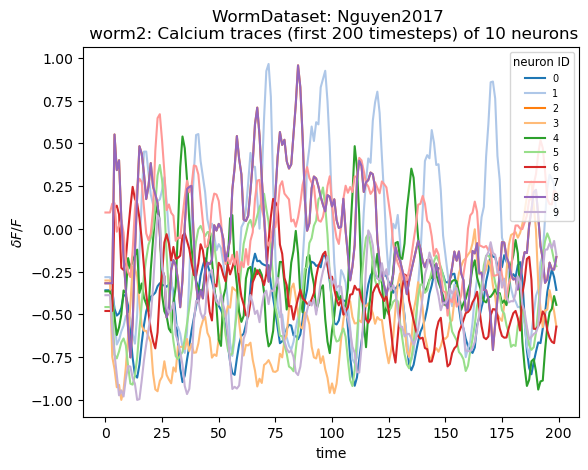

In [6]:
#@title Nguyen et al., PLOS CompBio 2017, _Automatically tracking neurons in a moving and deforming brain_
#@markdown Source: https://ieee-dataport.org/open-access/tracking-neurons-moving-and-deforming-brain-dataset

# load a dataset
Nguyen2017 = load_dataset('Nguyen2017')
print(Nguyen2017.keys())

# get data for one worm
worm = np.random.choice(list(Nguyen2017.keys()))
single_worm_dataset = pick_worm(Nguyen2017, worm)

# plot the calcium activity
plot_worm_data(single_worm_dataset, 'WormDataset: Nguyen2017 \n %s'%worm)

dict_keys(['worm0', 'worm1', 'worm2', 'worm3', 'worm4', 'worm5', 'worm6', 'worm7', 'worm8', 'worm9', 'worm10', 'worm11'])


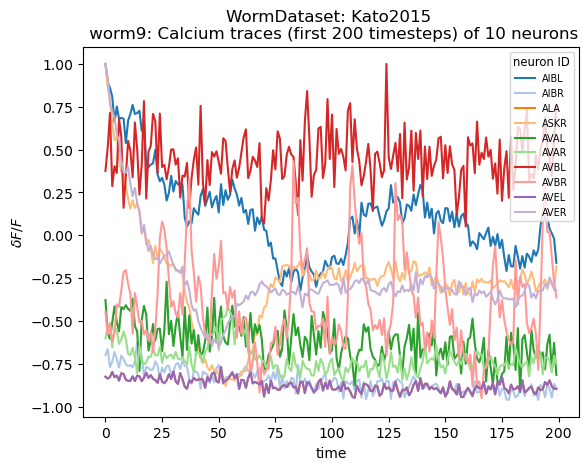

In [7]:
#@title Kato et al., Cell 2015, _Global Brain Dynamics Embed the Motor Command Sequence of Caenorhabditis elegans_
#@markdown Source: https://osf.io/2395t/

# load the dataset
Kato2015 = load_dataset('Kato2015')
print(Kato2015.keys())

# get data for one worm
worm = np.random.choice(list(Kato2015.keys()))
single_worm_dataset = pick_worm(Kato2015, worm)

# plot the calcium activity
plot_worm_data(single_worm_dataset, 'WormDataset: Kato2015 \n %s'%worm)

In [17]:
#@title Nichols et al., Science 2017, _A global brain state underlies C. elegans sleep behavior_
#@markdown Source: https://osf.io/kbf38/

# load the dataset
Nichols2017 = load_dataset('Nichols2017')
print(Nichols2017.keys())

# get data for one worm
worm = np.random.choice(list(Nichols2017.keys()))
single_worm_dataset = pick_worm(Nichols2017, worm)

# plot the calcium activity
plot_worm_data(single_worm_dataset, 'WormDataset: Nichols2017 \n %s'%worm)

dict_keys(['worm0', 'worm1', 'worm2', 'worm3', 'worm4', 'worm5', 'worm6', 'worm7', 'worm8', 'worm9', 'worm10', 'worm11', 'worm12', 'worm13', 'worm14', 'worm15', 'worm16', 'worm17', 'worm18', 'worm19', 'worm20', 'worm21', 'worm22', 'worm23', 'worm24', 'worm25', 'worm26', 'worm27', 'worm28', 'worm29', 'worm30', 'worm31', 'worm32', 'worm33', 'worm34', 'worm35', 'worm36', 'worm37', 'worm38', 'worm39', 'worm40', 'worm41', 'worm42', 'worm43'])


KeyError: 'named_neuron_to_idx'

dict_keys(['worm0', 'worm1', 'worm2', 'worm3', 'worm4', 'worm5', 'worm6', 'worm7', 'worm8', 'worm9', 'worm10', 'worm11', 'worm12', 'worm13', 'worm14', 'worm15', 'worm16', 'worm17', 'worm18'])


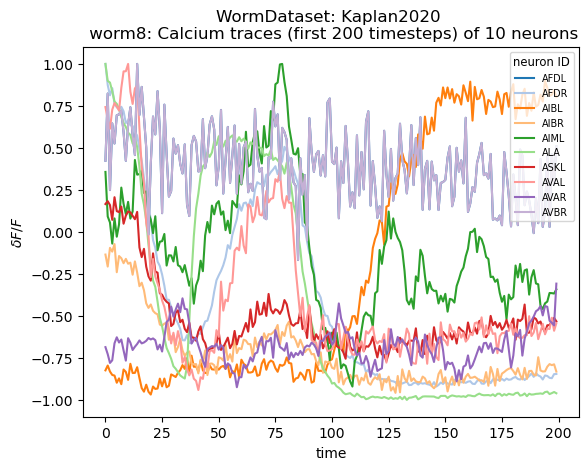

In [9]:
#@title Kaplan et al., Neuron 2020, _Nested Neuronal Dynamics Orchestrate a Behavioral Hierarchy across Timescales_
#@markdown Source: https://osf.io/9nfhz/

# load the dataset
Kaplan2020 = load_dataset('Kaplan2020')
print(Kaplan2020.keys())

# get data for one worm
worm = np.random.choice(list(Kaplan2020.keys()))
single_worm_dataset = pick_worm(Kaplan2020, worm)

# plot the calcium activity
plot_worm_data(single_worm_dataset, 'WormDataset: Kaplan2020 \n %s'%worm)

dict_keys(['worm0', 'worm1', 'worm2', 'worm3', 'worm4', 'worm5'])


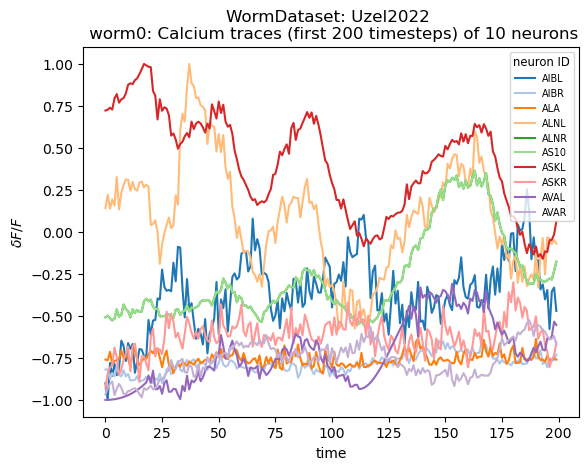

In [10]:
#@title Uzel et al., Cell CurrBio 2022, _A set of hub neurons and non-local connectivity features support global brain dynamics in C. elegans_
#@markdown Source: https://osf.io/3vkxn/

# # load the dataset
Uzel2022 = load_dataset('Uzel2022')
print(Uzel2022.keys())

# get data for one worm
worm = np.random.choice(list(Uzel2022.keys()))
single_worm_dataset = pick_worm(Uzel2022, worm)

# plot the calcium activity
plot_worm_data(single_worm_dataset, 'WormDataset: Uzel2022 \n %s'%worm)

dict_keys(['worm0', 'worm1', 'worm2', 'worm3', 'worm4', 'worm5', 'worm6', 'worm7', 'worm8', 'worm9', 'worm10', 'worm11'])


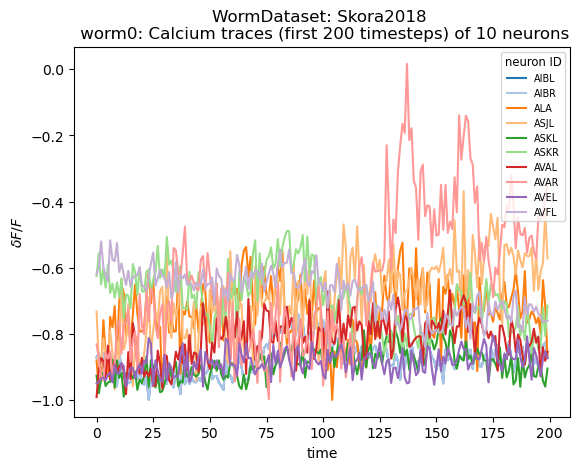

In [11]:
#@title Skora et al., Cell Reports 2018, _Energy Scarcity Promotes a Brain-wide Sleep State Modulated by Insulin Signaling in C. elegans_
#@markdown Source: https://osf.io/za3gt/ 

# # load the dataset
Skora2018 = load_dataset('Skora2018')
print(Skora2018.keys())

# get data for one worm
worm = np.random.choice(list(Skora2018.keys()))
single_worm_dataset = pick_worm(Skora2018, worm)

# plot the calcium activity
plot_worm_data(single_worm_dataset, 'WormDataset: Skora2018 \n %s'%worm)

### What's the distinction between "whole-brain" and "whole-nervous system" recordings? 

The nervous system of the C. elegans hermaphrodite is composed of 302 neurons that are organized in several 
ganglia in the head and tail and into a spinal cord-like ventral nerve cord [1]. The majority of the neurons 
is located in the head, where they are organised in a number of ganglia surrounding the pharynx, forming the 
brain of the animal [2].

We will use the the richer whole-nervous system data, which is stored the file `Neuron2019_Data_RIShisCl.mat`. 

References:
- [1] http://www.wormbook.org/chapters/www_specnervsys.2/neurogenesis.html<br>
- [2] https://www.sfu.ca/biology/faculty/hutter/hutterlab/research/Ce_nervous_system.html<br>

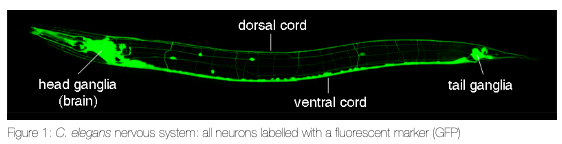

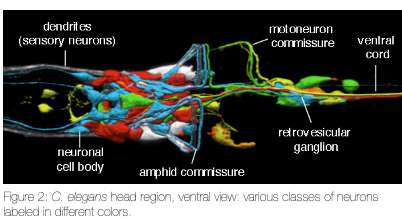

# Selecting single worm data.

This worm will be used in the rest of this notebook.

In [12]:
#@title Choose one of the datasets to work with.
#@markdown 

# choose your dataset
dataset_name = 'Kato2015'
all_worms_dataset = load_dataset(dataset_name)
print('Chosen dataset:', dataset_name)
print('Total number of worms:', len(all_worms_dataset))
print()

Chosen dataset: Kato2015
Total number of worms: 12



In [13]:
#@title Find neurons that are consistently tracked across all worms in this dataset.
#@markdown By doing this for each of the datasets with labelled neurons, we 
#@markdown found one neuron that is consistently tracked across all worms in all
#@markdown the datasets: the "AVAL" neuron.

# consistent neurons in the present dataset
intersection = find_reliable_neurons(all_worms_dataset)
print(len(intersection), "consistent neurons in this dataset:", intersection, end="\n\n")

# consistent neurons across all the datasets
stable_neurons = set(NEURONS_302)
for dn in VALID_DATASETS - {'Nguyen2017'}: 
    stable_neurons &= set(find_reliable_neurons(load_dataset(dn)))
print(len(stable_neurons), "consistent neurons in all datasets:", sorted(stable_neurons), end="\n\n") 

12 consistent neurons in this dataset: ['AIBL', 'AIBR', 'ALA', 'AVAL', 'AVAR', 'AVEL', 'RID', 'RIML', 'RIMR', 'RMED', 'RMEL', 'VB2']

1 consistent neurons in all datasets: ['AVAL']



### The AVAL neuron was reliably tracked across worms in multiple independent open source worm datasets.

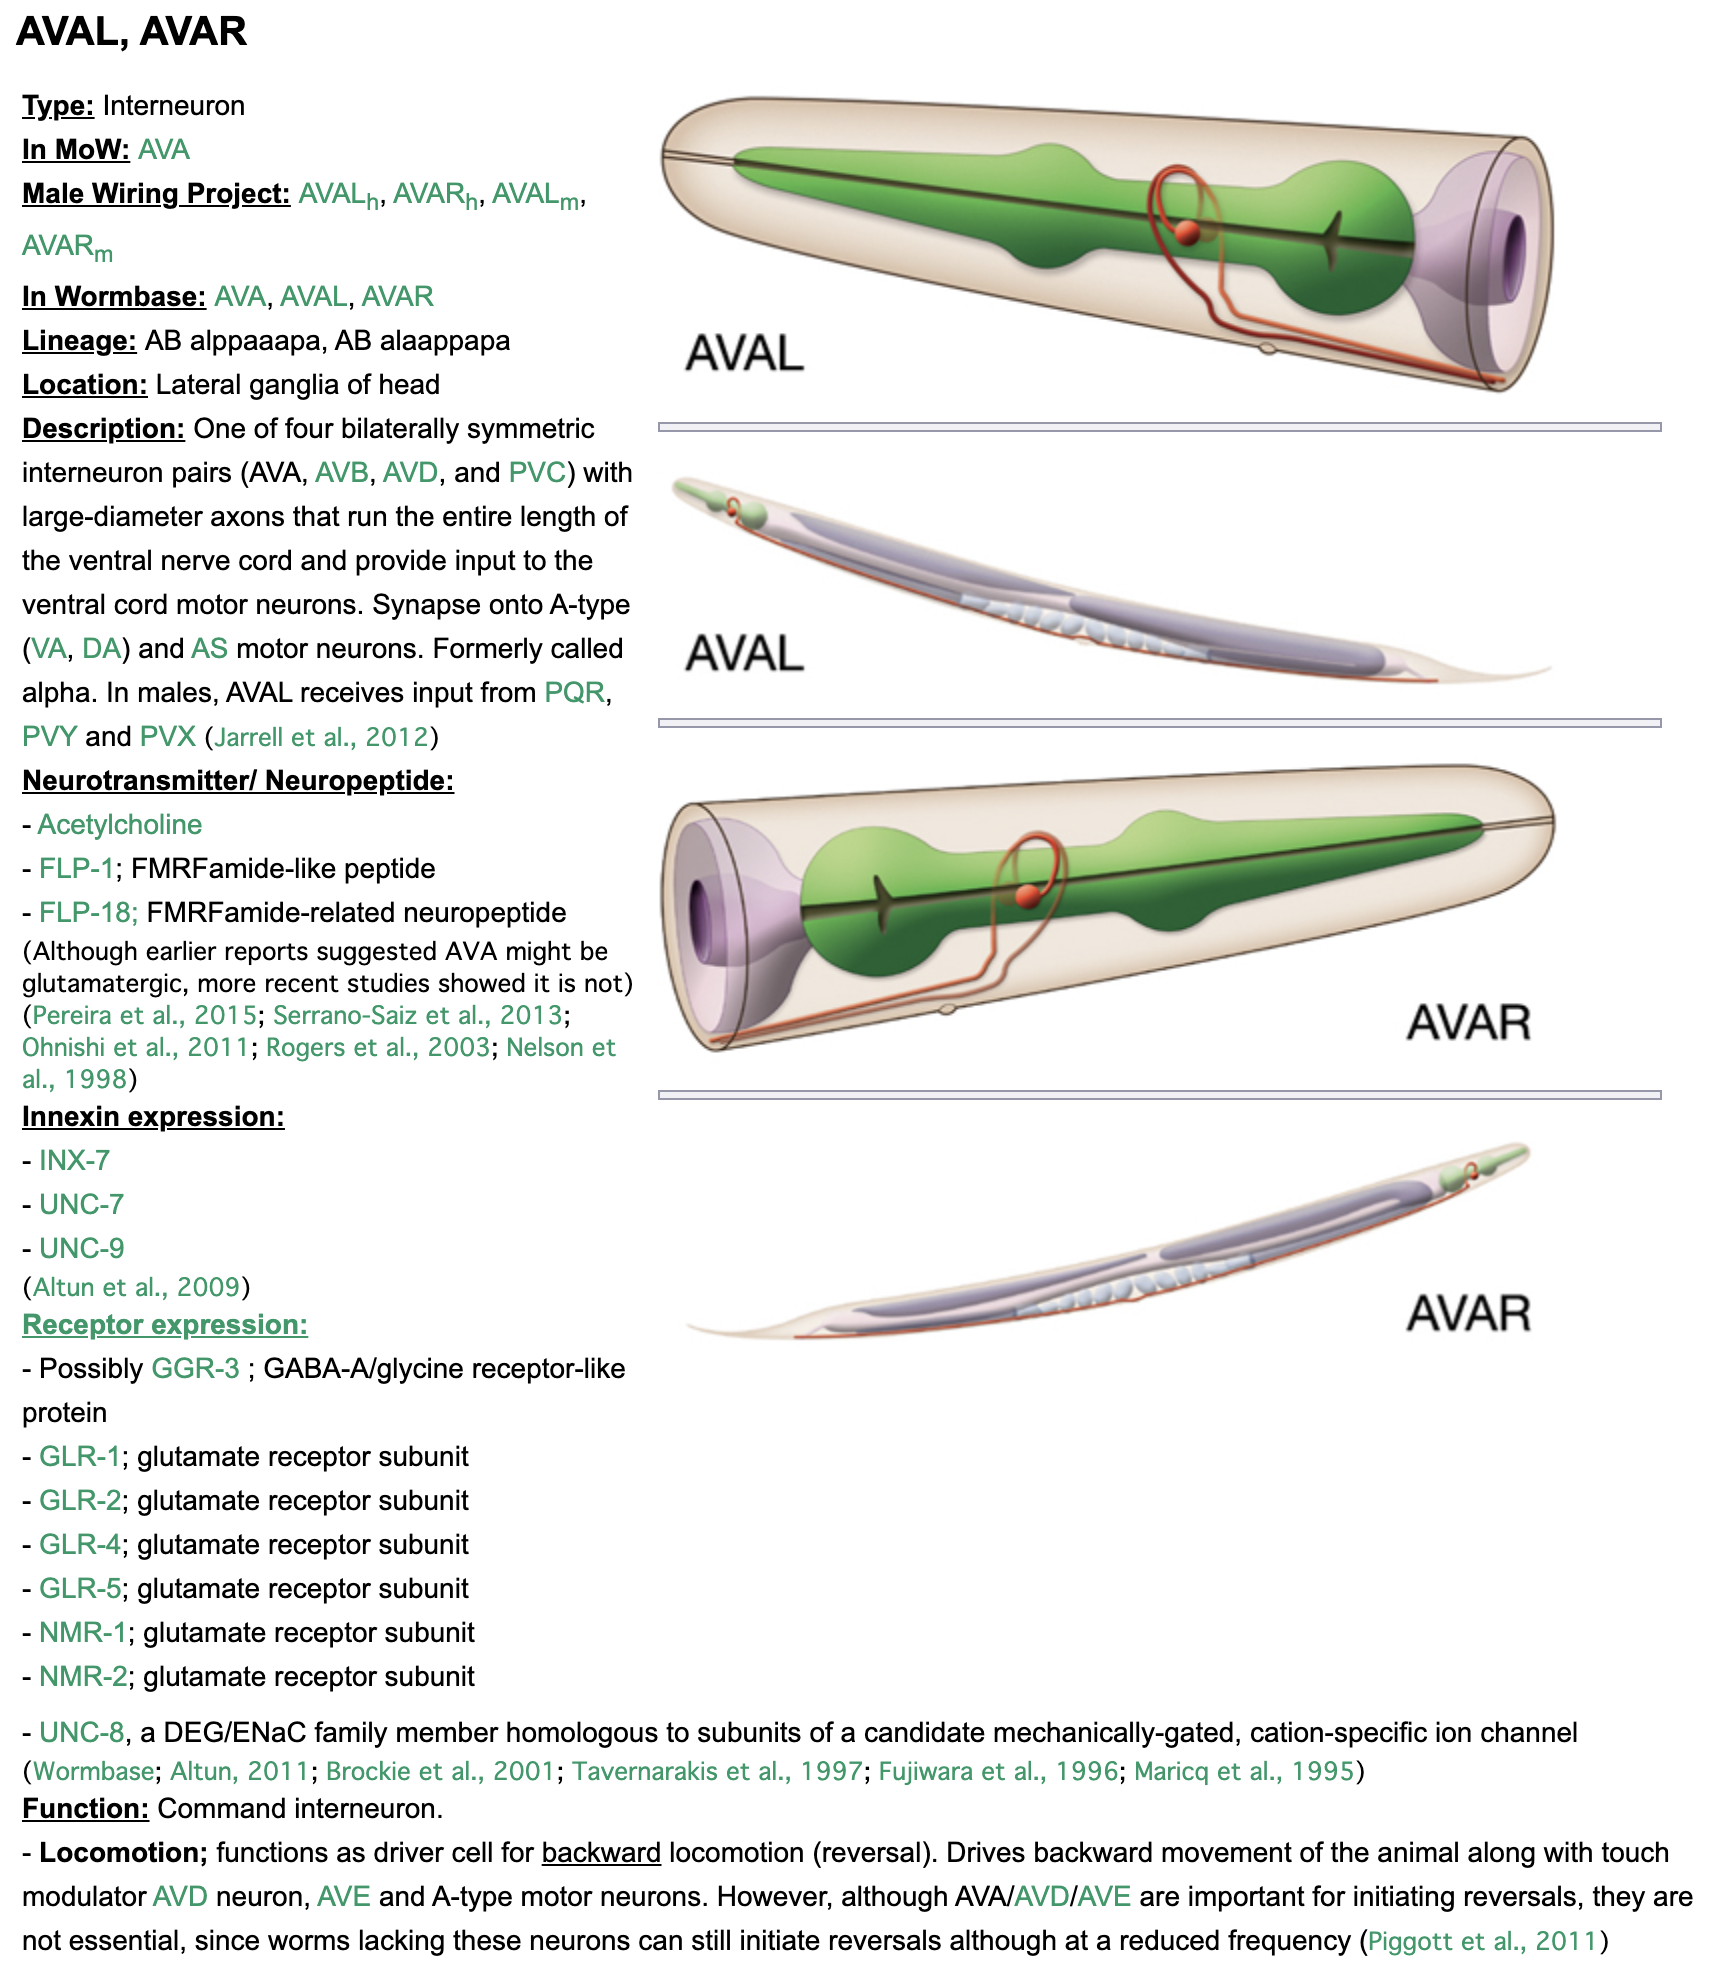


WORM0
mean residual: -0.00036800830329009764



/Users/quileesimeon/opt/anaconda3/envs/worm-graph/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


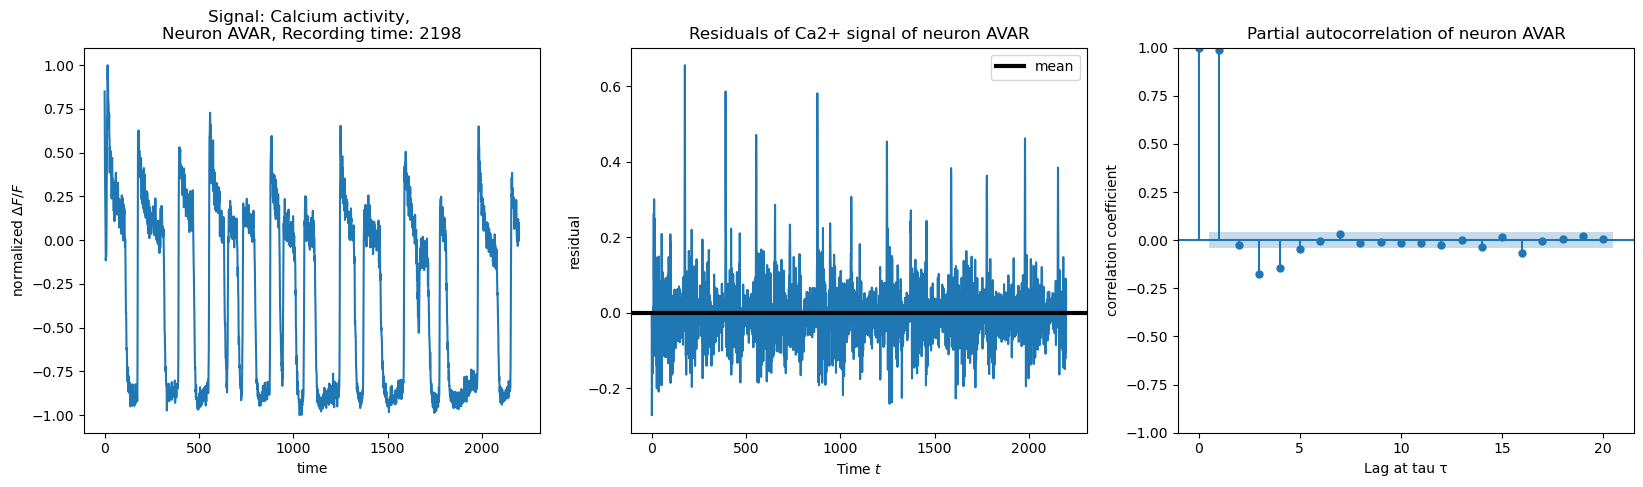


WORM1
mean residual: 8.21770260480032e-05



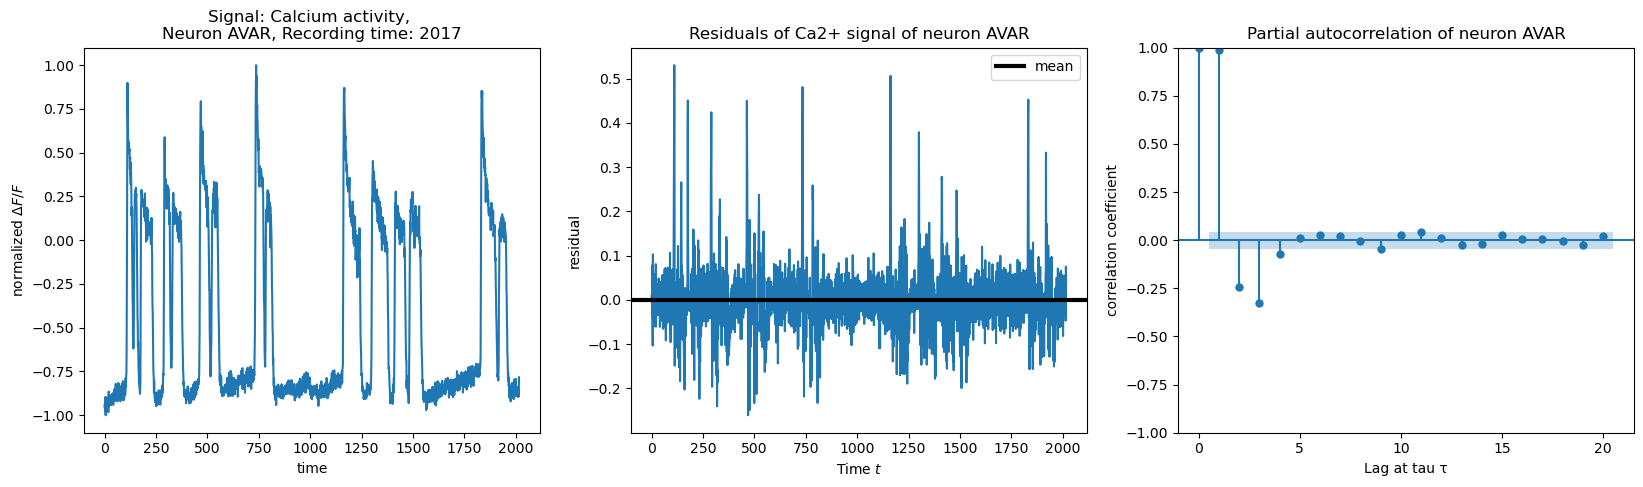


WORM2
mean residual: 5.6646655060606174e-05



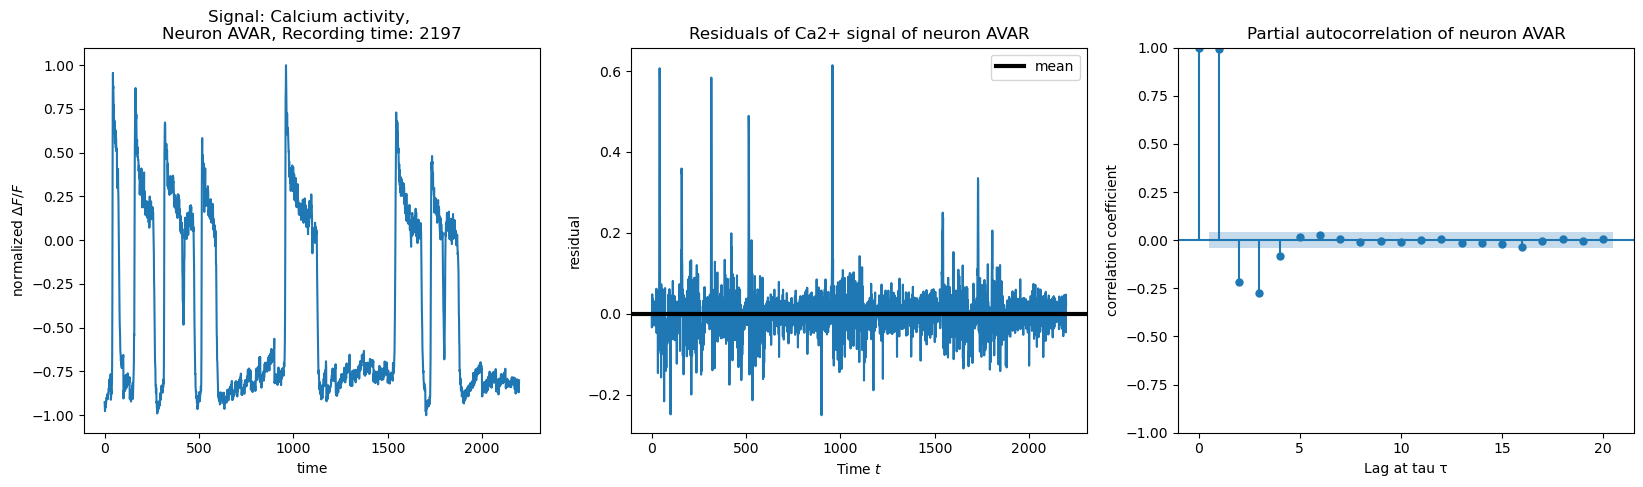


WORM3
mean residual: -0.0006095498794264797



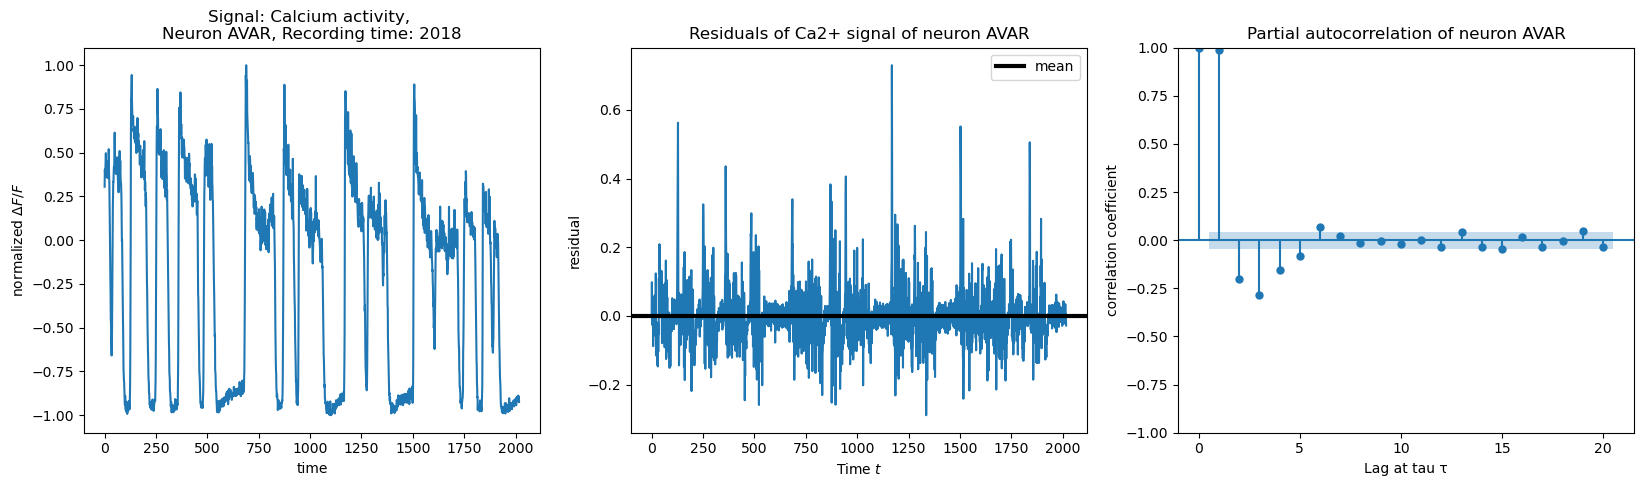


WORM4
mean residual: 0.00011183705291967466



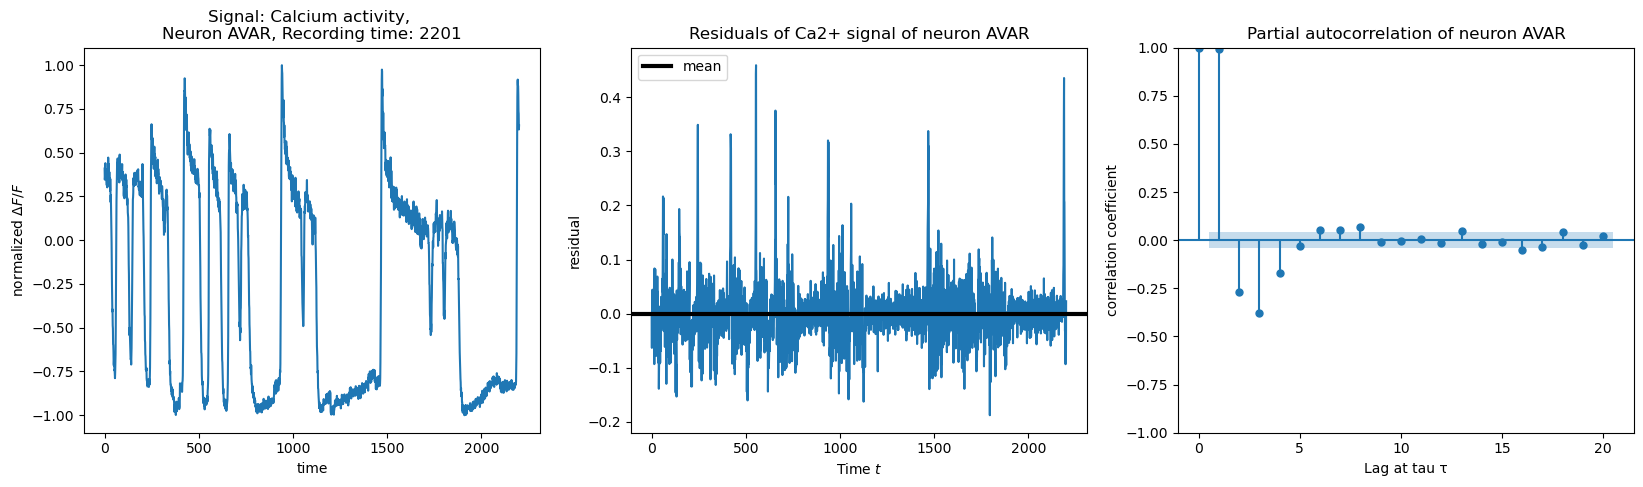


WORM5
mean residual: 5.1278841929520505e-05



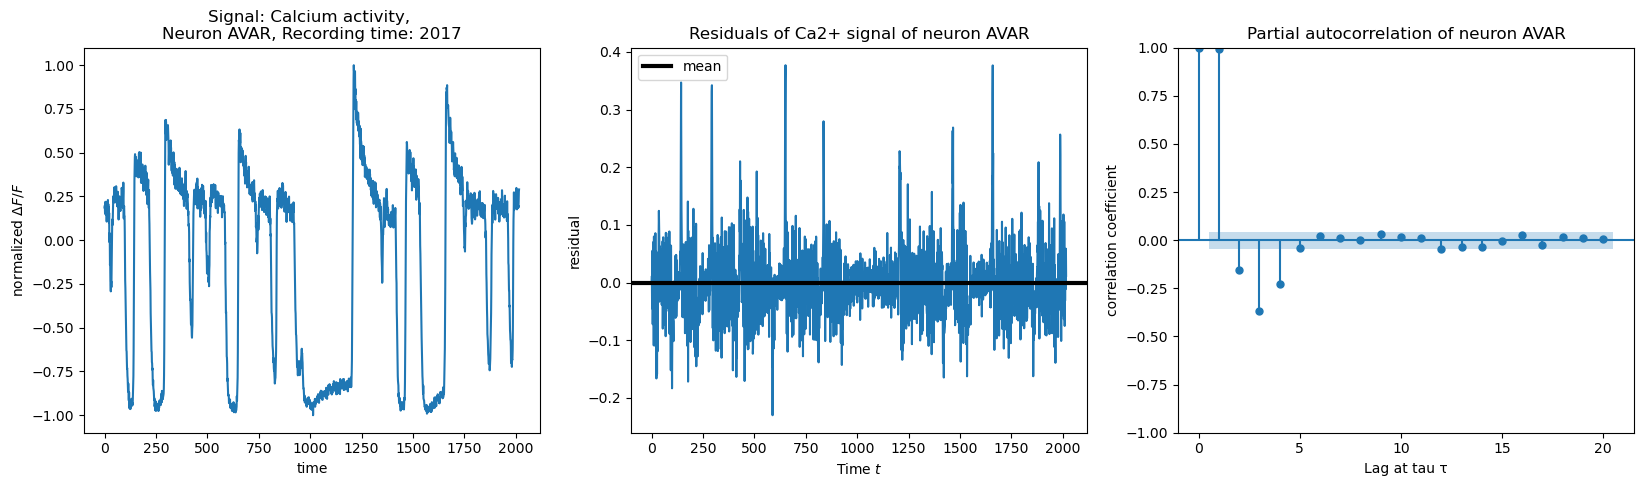


WORM6
mean residual: -0.00036183529548678025



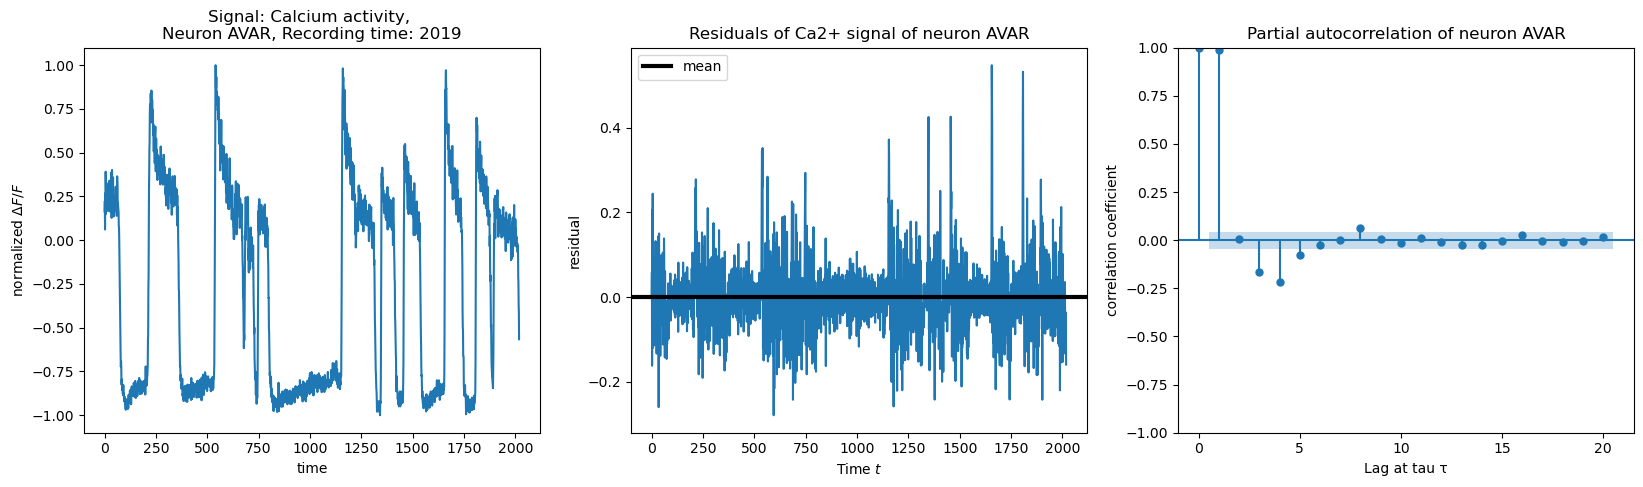


WORM7
mean residual: 6.273884183272824e-06



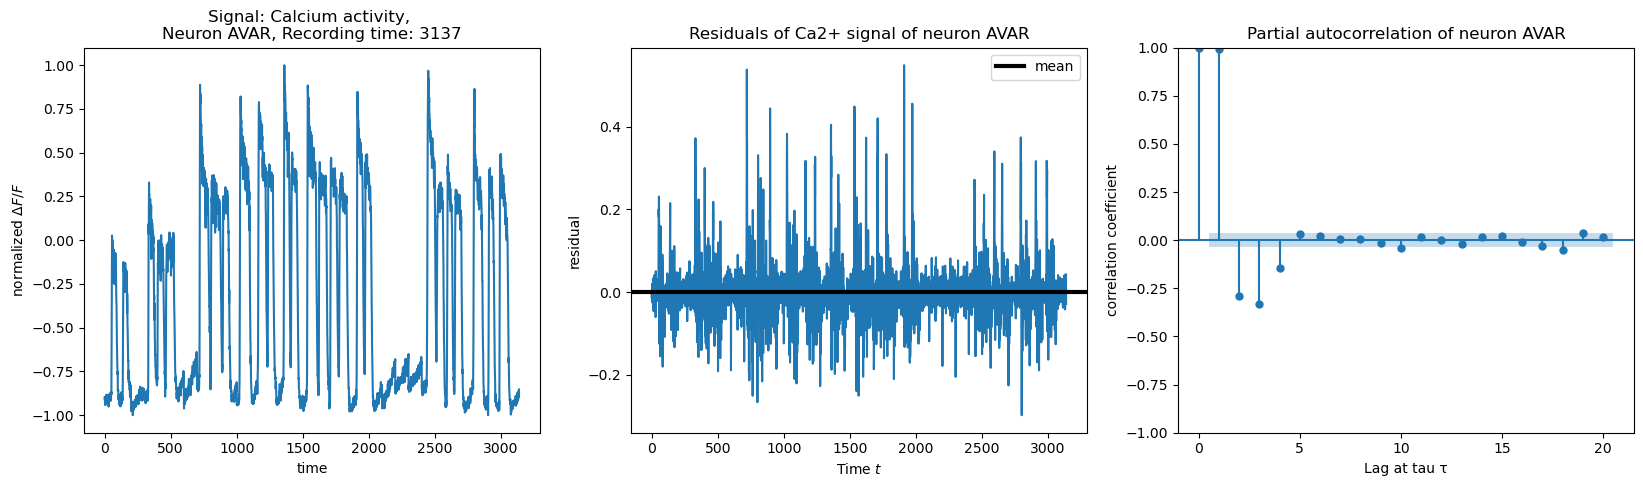


WORM8
mean residual: -0.00039364044771868093



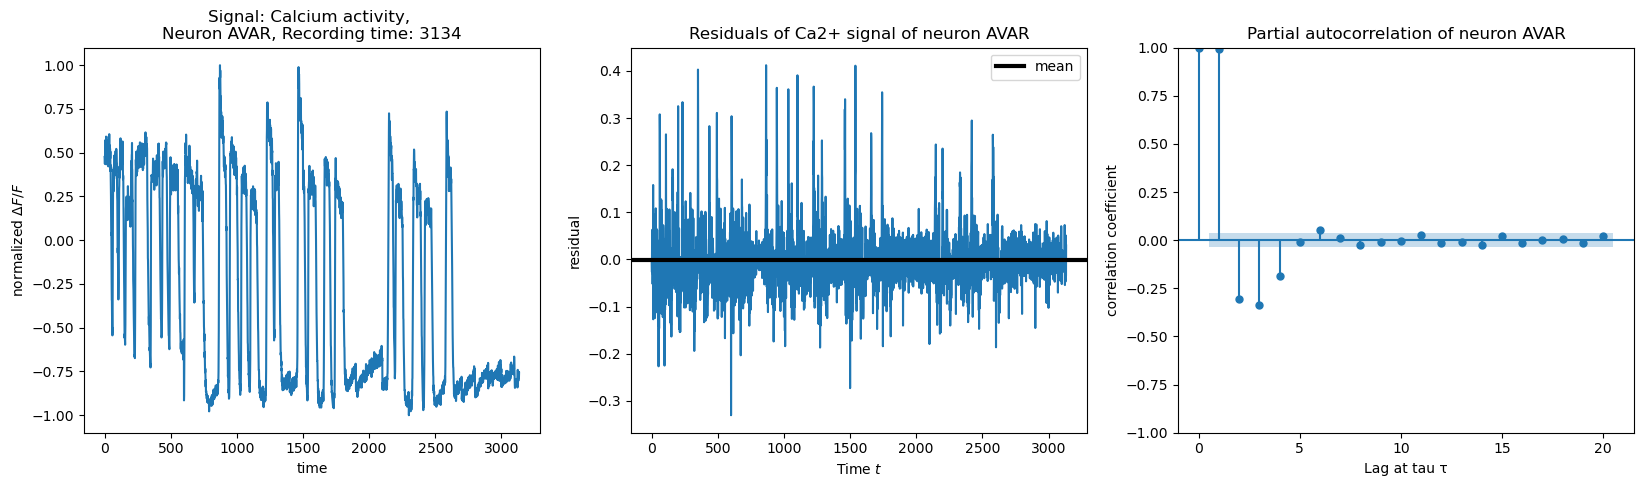


WORM9
mean residual: -0.0004907437333365059



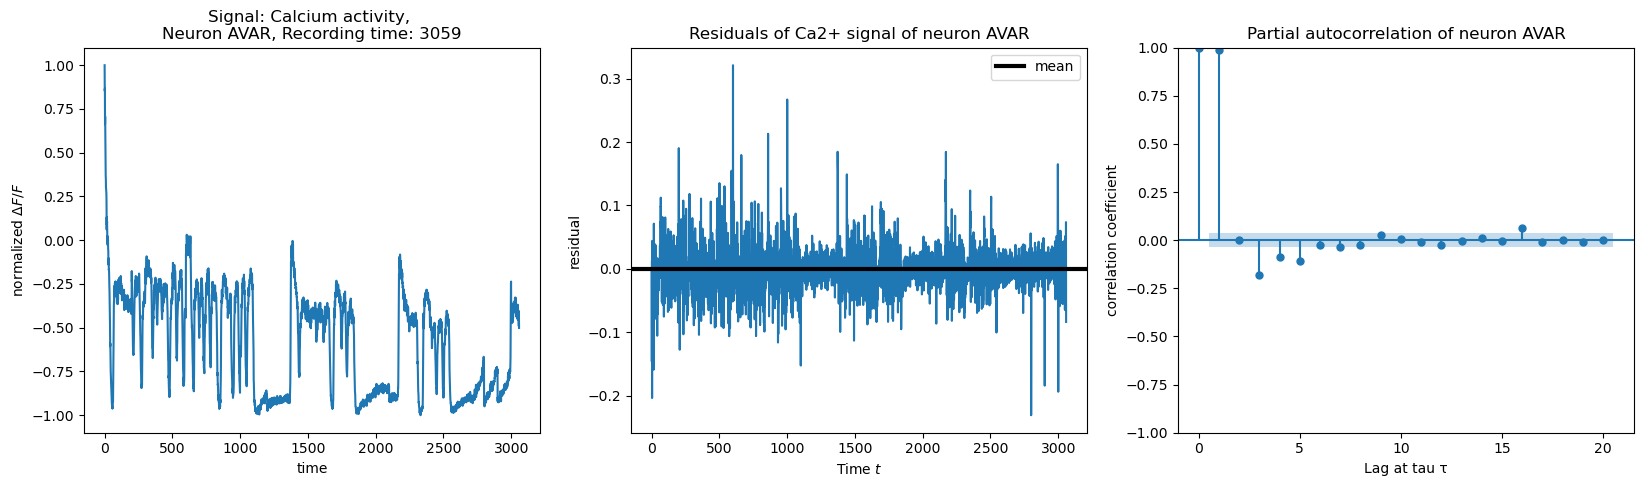


WORM10
mean residual: -0.0003670278418689801



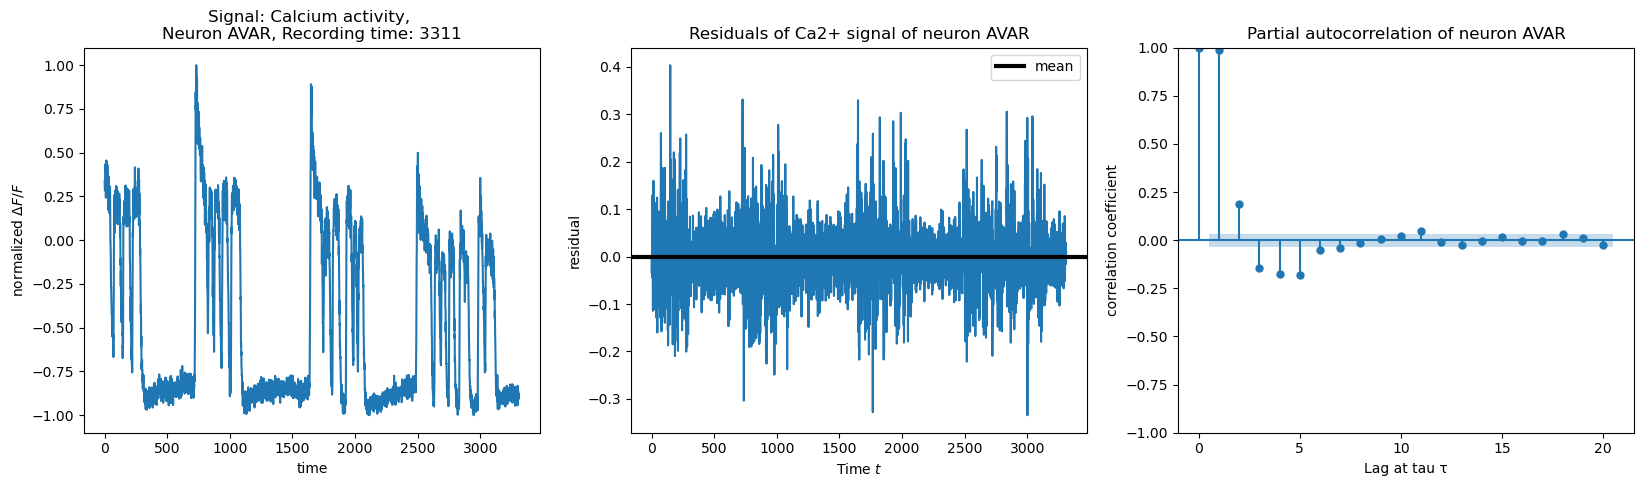


WORM11
mean residual: 0.00029720325939305896



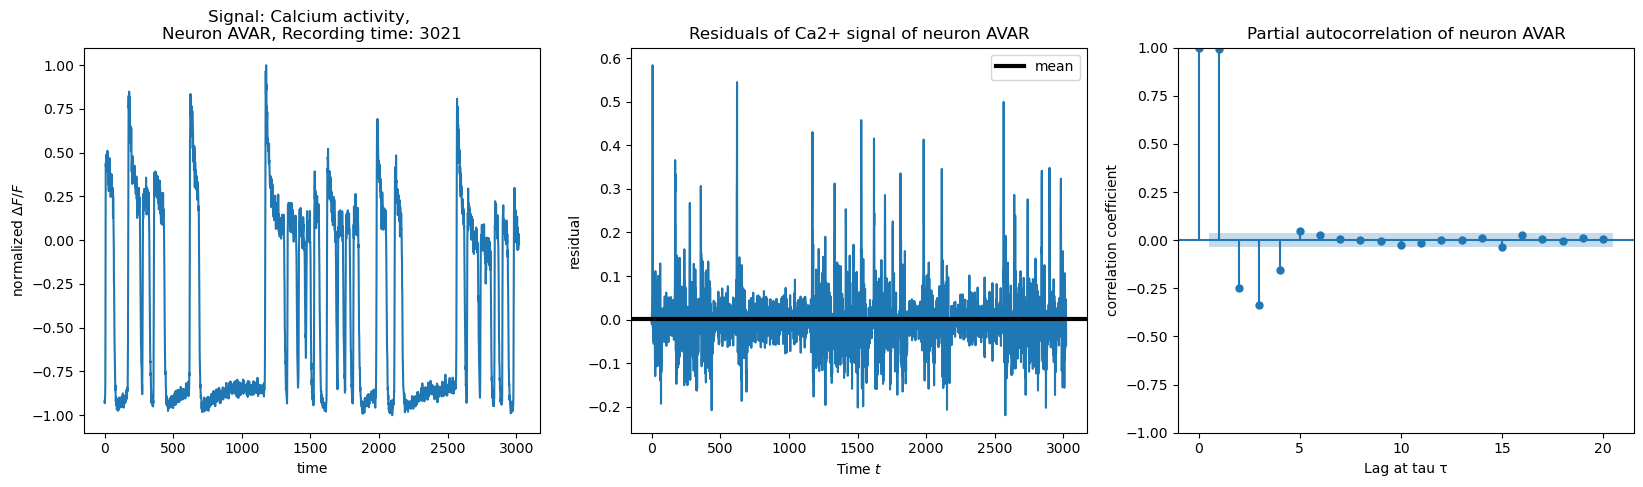

In [15]:
#@title Plot one of the reliably tracked neurons for each worm.
#@markdown 

neuron = np.random.choice(intersection)
for i, worm in enumerate(all_worms_dataset):
  print()
  print(worm.upper())
  single_worm_dataset = pick_worm(all_worms_dataset, worm)
  neuron_to_idx = single_worm_dataset["named_neuron_to_idx"]
  neuron_idx = neuron_to_idx[neuron]
  plot_single_neuron_signals(single_worm_dataset, neuron_idx)


WORM0


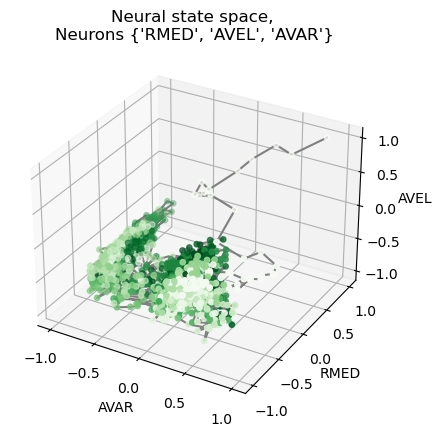


WORM1


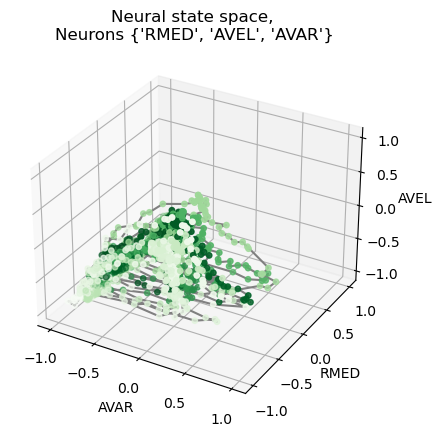


WORM2


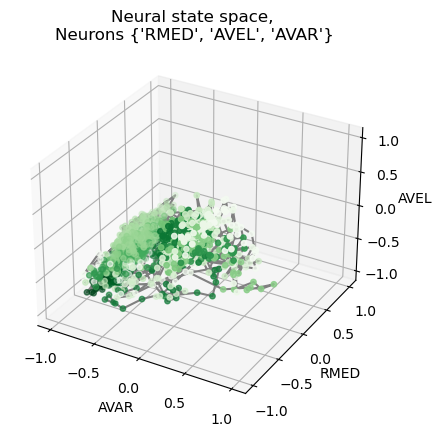


WORM3


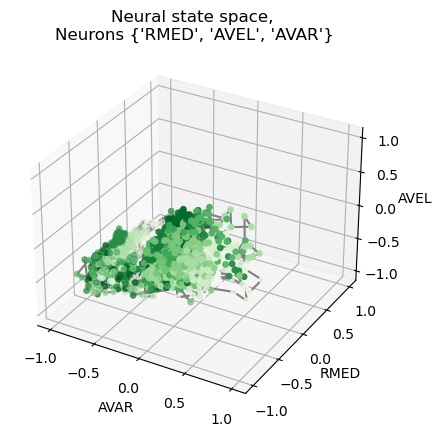


WORM4


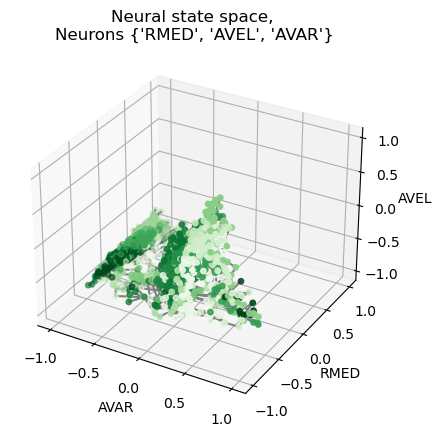


WORM5


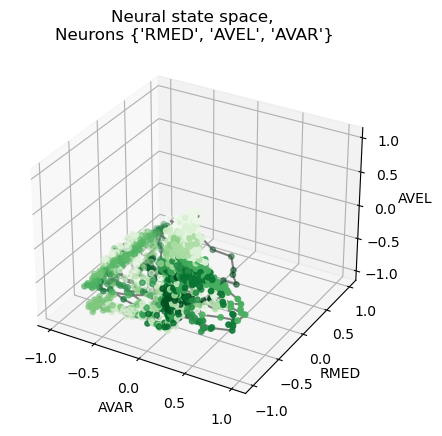


WORM6


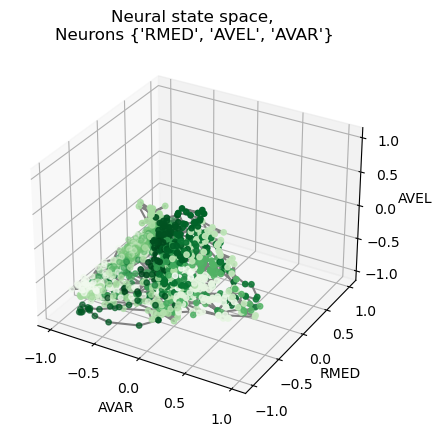


WORM7


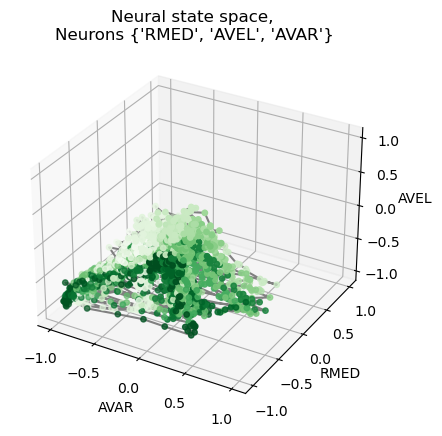


WORM8


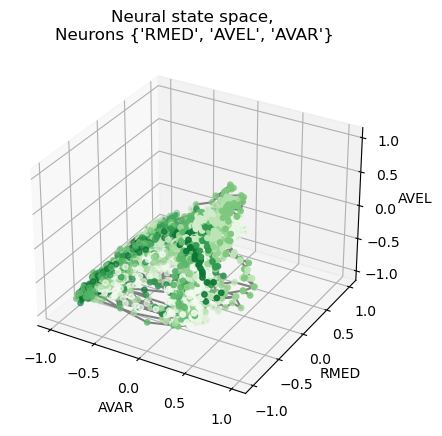


WORM9


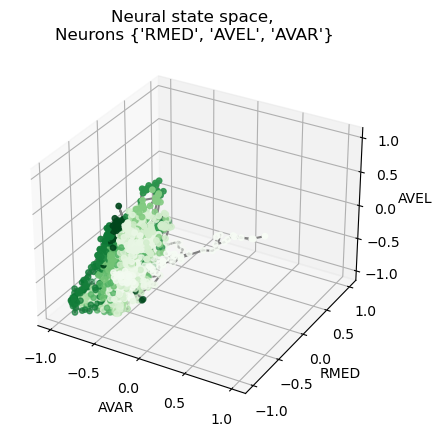


WORM10


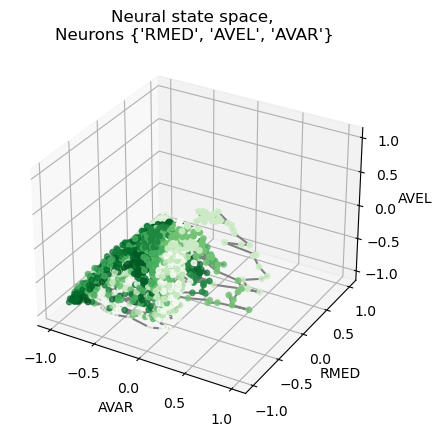


WORM11


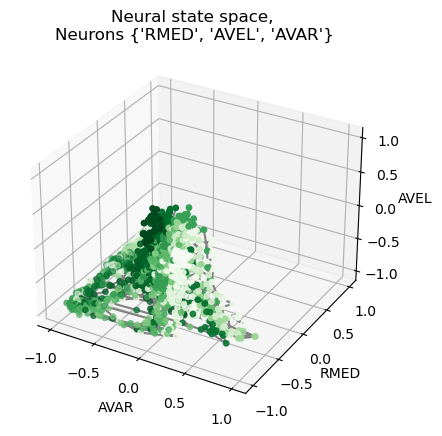

In [16]:
#@title Plot the state-space of 3 consistently tracked neurons for each worm.
#@markdown

inds = np.random.choice(np.arange(len(intersection)), 3, replace=False)
neurons = np.array(intersection)[inds].tolist()

for i, worm in enumerate(all_worms_dataset):
    print()
    print(worm.upper())
    # retrieve this worm's data
    single_worm_dataset = pick_worm(all_worms_dataset, worm)
    # unpack the calcium data
    neuron_to_idx = single_worm_dataset["named_neuron_to_idx"]
    max_time = single_worm_dataset["max_time"]
    # get the data for the 3 selected neurons
    named_data = single_worm_dataset["named_data"].squeeze().numpy()
    indices = np.array([neuron_to_idx[neuron] for neuron in neurons])
    neurons_data = named_data[:, indices]
    # plot the state space
    ax = plt.axes(projection='3d')
    ax.plot3D(neurons_data[:,0], neurons_data[:,1], neurons_data[:,2], 'gray')
    ax.scatter3D(neurons_data[:,0], neurons_data[:,1], neurons_data[:,2], 
              c=np.arange(max_time), s=15, cmap='Greens',
              edgecolors='face')
    ax.set_xlabel(neurons[0])
    ax.set_ylabel(neurons[1])
    ax.set_zlabel(neurons[2])
    ax.set_title("Neural state space, \nNeurons %s" % set(neurons))
    plt.show()
    

In [ ]:
#@title Now pick one worm from the chosen dataset.
#@markdown 

# get data for one worm
worm = np.random.choice(list(all_worms_dataset.keys()))
single_worm_dataset = pick_worm(all_worms_dataset, worm)
print('Picked worm:', worm)
print()

# get the calcium data for this worm
calcium_data = single_worm_dataset["all_data"]
print('Worm calcium-signal dataset:', calcium_data.shape)
print()

# get max time and number of neurons
max_time = single_worm_dataset['max_time']
num_neurons = single_worm_dataset['num_neurons']
print('Recording length: %s \nNumber of neurons: %s'%(max_time, num_neurons))
print()

In [ ]:
#@title Visualize example train and test samples for a single neuron.
#@markdown 

# get the neuron to idx map 
neuron_to_idx = single_worm_dataset["named_neuron_to_idx"]
# pick a neuron 
neuron_idx = np.random.choice(list(neuron_to_idx.values())) 
# plot train and test samples
plot_neuron_train_test_samples(single_worm_dataset, neuron_idx, 
                               num_samples=3, seq_len=1000, tau=100)

# Pytorch dataloaders for our data.


In [ ]:
#@title Map-style dataset.
#@markdown We have implemented a datset `MapDataset` and associated batch sampler 
#@markdown `BatchSampler` in `worm_utils.py`.<br> This cell is only meant to illustrate 
#@markdown how to build a dataset and dataloader.

from worm_utils import MapDataset, BatchSampler

dataset = MapDataset(new_calcium_data, seq_len=[7,9,11], size=3*max_time)
print('size', dataset.size, 'features', dataset.num_features)
print()

# each batch contains all samples of a fixed length
data_sampler = BatchSampler(dataset.batch_indices)
loader = torch.utils.data.DataLoader(dataset, batch_sampler=data_sampler)

# testing the data-loader
gen = iter(loader)
X, Y, meta = next(gen) 
print('First batch:', X.shape, Y.shape, list(map(lambda item: 
                                                (item[0], item[-1].shape), 
                                                meta.items()))) 
print()
X, Y, meta = next(gen)
print('Second batch:', X.shape, Y.shape, list(map(lambda item: 
                                                 (item[0], item[-1].shape), 
                                                 meta.items()))) 
print()
print('Data on GPU?', X.is_cuda, Y.is_cuda) # check if data on GPU

size 12351 features 302

First batch: torch.Size([4115, 11, 302]) torch.Size([4115, 11, 302]) [('seq_len', torch.Size([4115])), ('start', torch.Size([4115])), ('end', torch.Size([4115])), ('tau', torch.Size([4115]))]

Second batch: torch.Size([4117, 9, 302]) torch.Size([4117, 9, 302]) [('seq_len', torch.Size([4117])), ('start', torch.Size([4117])), ('end', torch.Size([4117])), ('tau', torch.Size([4117]))]

Data on GPU? True True


# _C. elegans_ residual neural activity prediction models.

We will train several different models to predict the residuals of real *C. elegans* neural activity and then plot loss function curves for various hyperparameters.

We would like to build models that take an arbitray length $L$ time-series of *C. elegans* neural activty and outputs a length $L$ time-series of the residuals of future neural activity.


For all models, we create datasets of sequences (slices of neural recordings).
The training dataset is made from the first half of the recordings.
The test dataset is made from the second half of the recordings.

In [ ]:
#@title Make a Pytorch-style train and test pipeline.
#@markdown This pipeline will be used by all models. 
#@markdown All models should include a method `loss_fn()` that specifies the
#@markdown loss function to be used with the model.

def train(loader, model, mask, optimizer, no_grad=False):
  """
  Train a model given a dataset for a single epoch.
    Args:
        loader: training set dataloader
        model: instance of a NetworkLSTM
        mask: mask which neurons in the dataset have real data
        optimizer: gradient descent optimizer with model params on it
    Returns:
        losses: dict w/ keys train_loss and base_train_loss
  """
  # set model to train
  model.train()
  criterion = model.loss_fn()
  base_loss, train_loss = 0, 0
  # Iterate in batches over the training dataset.
  for i, data in enumerate(loader): 
      X_train, Y_train, meta = data # (batch_size, seq_len, num_neurons)
      tau = meta['tau'][0]
      optimizer.zero_grad()  # Clear gradients.
      # Baseline: loss if the model predicted the residual to be 0
      base = criterion(torch.zeros_like(Y_train[:,:,mask]), 
                       (Y_train-X_train)[:,:,mask])/(tau+1)
      # Train
      Y_tr = model(X_train) # Forward pass.
      Y_tr.retain_grad()
      Y_tr.register_hook(lambda grad: grad * mask.double())
      loss = criterion(Y_tr[:,:,mask], (Y_train-X_train)[:,:,mask])/(tau+1) # Compute training loss.
      loss.backward()  # Derive gradients.
      if no_grad:
        optimizer.zero_grad()
      optimizer.step()  # Update parameters based on gradients.
      # Store train and baseline loss.
      base_loss += base.detach().item()
      train_loss += loss.detach().item()
  # Average train and baseline losses
  losses = {'train_loss': train_loss/(i+1), 'base_train_loss': base_loss/(i+1)}
  # return mean train and baseline losses
  return losses


@torch.no_grad()
def test(loader, model, mask):
  """
  Evaluate a model on a given dataset.
      loader: test/validation set dataloader
      model: instance of a NetworkLSTM
      mask: mask which neurons in the dataset have real data
  Returns:
      losses: dict w/ keys test_loss and base_test_loss
  """
  model.eval() # this turns of grad
  criterion = model.loss_fn()
  base_loss, test_loss = 0, 0
  # Iterate in batches over the validation dataset.
  for i, data in enumerate(loader): 
    X_test, Y_test, meta = data # (batch_size, seq_len, num_neurons)
    tau = meta['tau'][0]
    # Baseline: loss if the model predicted the residual to be 0
    base = criterion(torch.zeros_like(Y_test[:,:,mask]), 
                     (Y_test-X_test)[:,:,mask])/(tau+1)
    # Test
    Y_te = model(X_test) # Forward pass.
    loss = criterion(Y_te[:,:,mask], (Y_test-X_test)[:,:,mask])/(tau+1) # Compute the validation loss.
    # Store test and baseline loss.
    base_loss += base.detach().item()
    test_loss += loss.detach().item()
  # Average test and baseline losses
  losses = {'test_loss': test_loss/(i+1), 'base_test_loss': base_loss/(i+1)}
  return losses


def optimize_model(dataset, model, mask=None, optimizer=None, num_epochs=100, 
                   seq_len=1, data_size=1000):
  """
  Creates train and test loaders given a task/dataset.
  Creates the optimizer given the model.
  Trains and validates the model for specified number of epochs.
  Returns a dict of epochs, and train, test and baseline losses.
  """
  # create the mask
  if mask is None:
    mask = torch.ones(302, dtype=torch.bool)
  assert mask.size(0) == 302 and mask.dtype == torch.bool
  mask.requires_grad = False
  mask = mask.to(device)
  # put model on device
  model = model.to(device)
  # create optimizer
  if optimizer is None:
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  # create MapDatasets
  max_time = len(dataset)
  train_dataset = MapDataset(dataset[:max_time//2], tau=1, seq_len=seq_len, 
                           increasing=False, reverse=True, size=data_size)
  test_dataset = MapDataset(dataset[max_time//2:], tau=1, seq_len=seq_len, 
                          increasing=False, reverse=True, size=2048) # fix test size
  # create train and test loaders
  train_sampler = BatchSampler(train_dataset.batch_indices)
  train_loader = torch.utils.data.DataLoader(train_dataset, 
                                            batch_sampler=train_sampler)
  test_sampler = BatchSampler(test_dataset.batch_indices)
  test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_sampler=test_sampler)
  # create log dictionary to return
  log = {'base_train_losses': [], 'base_test_losses': [], 
         'train_losses': [], 'test_losses': [], 'epochs': []}
  log.update({'data_size': train_dataset.size, 'seq_len': seq_len})
  # iterate over the training data multiple times
  for epoch in range(num_epochs+1):
    # train the model
    train_log = train(train_loader, model, mask, optimizer, no_grad=(epoch==0))
    test_log = test(test_loader, model, mask)
    base_train_loss, train_loss = train_log['base_train_loss'], train_log['train_loss']
    base_test_loss, test_loss = test_log['base_test_loss'], test_log['test_loss']
    if epoch % (num_epochs//100) == 0:
      print(f"Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val. Loss: {test_loss:.4f}")
      log['epochs'].append(epoch)
      log['base_train_losses'].append(base_train_loss)
      log['base_test_losses'].append(base_test_loss)
      log['train_losses'].append(train_loss)
      log['test_losses'].append(test_loss)
  # return optimized model
  return model, log

In [ ]:
#@title Functions for training on more data and multiple worms.
#@markdown 

from worm_utils import plot_loss_log, plot_before_after_weights, model_predict
from worm_utils import plot_target_prediction, plot_correlation_scatter


def more_data_training(model_class, single_worm_dataset, num_epochs=100,
                       worm="worm**", model_name="", seq_len=1, plotting=False):
  """
  A function to investigate the effect of the amount of data 
  (sequence length fixed) on the training and generalization of a model.
  """
  results_list = []
  # parse worm dataset
  # get the calcium data for this worm
  calcium_data = single_worm_dataset['data']
  # get the neuron to idx map 
  neuron_id = single_worm_dataset['neuron_id']
  id_neuron = dict((v,k) for k,v in neuron_id.items())
  # get max time and number of neurons
  max_time = single_worm_dataset['max_time']
  num_neurons = single_worm_dataset['num_neurons']
  # assign each neuron to a particular slot
  slot_neuron = dict((k,v) for k,v in enumerate(neurons_302))
  neuron_slot = dict((v,k) for k,v in enumerate(neurons_302))
  # identify slots of this dataset's tracked with label neurons 
  tracked_slot = dict((k, neuron_slot[k]) for k in neuron_id if not k.isnumeric())
  slot_tracked = dict((v, k) for k, v in tracked_slot.items())
  # pick a neuron from the tracked subset
  slot_idx = np.random.choice(list(slot_tracked))
  neuron = slot_neuron[slot_idx]
  neuron_idx = neuron_id[neuron]
  # create the new calcium data structure and mask
  new_calcium_data = torch.zeros(max_time, 302, 1, dtype=calcium_data.dtype)
  mask = torch.zeros(302, dtype=torch.bool)
  for slot, neuron in slot_neuron.items():
    if neuron in neuron_id:
      id = neuron_id[neuron]
      new_calcium_data[:, slot, :] = calcium_data[:, id, :]
      mask[slot] = True
  # iterate over different dataset sizes
  data_sizes = np.logspace(5, np.floor(np.log2(max_time//2)), 10, 
                           base=2, dtype=int)
  print("Training dataset sizes we will try:", data_sizes.tolist())
  for data_size in data_sizes:
    print()
    print("Dataset size", data_size) 
    # initialize model 
    model = model_class(input_size=302).double()
    # train the model on this amount of data
    model, log = optimize_model(new_calcium_data, model, mask, 
                                num_epochs=num_epochs, seq_len=seq_len, 
                                data_size=data_size)
    # put the worm and neuron in log
    log['worm'] = worm
    log['neuron_idx'] = neuron_idx
    log['neuron'] = neuron
    log['num_neurons'] = num_neurons
    # true dataset size
    size = log['data_size']
    # predict with the model
    targets, predictions = model_predict(new_calcium_data, model)
    # log targets and predictions
    log['targets'] = targets
    log['predictions'] = predictions
    if plotting:
      # plot loss curves
      plot_loss_log(log, plt_title="%s, %s neurons, data size %s, seq. len %s "
      "\n %s Model: Loss curves"%(worm.upper(), num_neurons, size, seq_len, 
                                  model_name))
      # plot prediction for a single neuron
      plot_target_prediction(targets[:, slot_idx], predictions[:, slot_idx],
                            plt_title="%s, neuron %s, data size %s, seq. len %s"
                            " \n %s Model: Ca2+ residuals prediction"%(
                                worm.upper(), neuron, size, seq_len, model_name))
      # plot scatterplot of all predictions
      plot_correlation_scatter(targets, predictions, plt_title="%s, %s neurons,"
      " data size %s, seq. len %s \n %s Model: Correlation of all neuron Ca2+ "
      "residuals"%(worm.upper(), num_neurons, size, seq_len, model_name))
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~")
    # add to results
    results_list.append((model, log))
  return results_list


def leave_one_worm_out_training(model_class, multi_worms_dataset, 
                                num_epochs=100, model_name="", seq_len=1, 
                                plotting=True):
  """
  Train on all but one worm in a dataset  
  and test on that one worm.
  """
  leaveOut_worm = np.random.choice(list(multi_worms_dataset))
  test_worm_dataset = multi_worms_dataset[leaveOut_worm]
  train_worms_dataset = {worm: dataset for worm, dataset in 
                         multi_worms_dataset.items() if worm != leaveOut_worm}
  # initialize the model
  model = model_class(input_size=302).double()
  # train the model sequentially on many worms
  train_results = multi_worm_training(model_class, train_worms_dataset, 
                                      num_epochs, model_name, seq_len, 
                                      plotting=False)
  model, train_log = train_results[-1]
  # get the calcium data for left out worm
  calcium_data = test_worm_dataset['data']
  # get the neuron to idx map 
  neuron_id = test_worm_dataset['neuron_id']
  id_neuron = dict((v,k) for k,v in neuron_id.items())
  # get max time and number of neurons
  max_time = test_worm_dataset['max_time']
  num_neurons = test_worm_dataset['num_neurons']
  # assign each neuron to a particular slot
  slot_neuron = dict((k,v) for k,v in enumerate(neurons_302))
  neuron_slot = dict((v,k) for k,v in enumerate(neurons_302))
  # identify slots of this dataset's tracked with label neurons 
  tracked_slot = dict((k, neuron_slot[k]) for k in neuron_id if not k.isnumeric())
  slot_tracked = dict((v, k) for k, v in tracked_slot.items())
  # pick a neuron from the tracked subset
  slot_idx = np.random.choice(list(slot_tracked))
  neuron = slot_neuron[slot_idx]
  neuron_idx = neuron_id[neuron]
  # create the new calcium data structure and mask
  new_calcium_data = torch.zeros(max_time, 302, 1, dtype=calcium_data.dtype)
  mask = torch.zeros(302, dtype=torch.bool)
  for slot, neuron in slot_neuron.items():
    if neuron in neuron_id:
      id = neuron_id[neuron]
      new_calcium_data[:, slot, :] = calcium_data[:, id, :]
      mask[slot] = True
  # predict with the model
  targets, predictions = model_predict(new_calcium_data, model)
  # create a log for this evaluation
  log = dict()
  log.update(train_log)
  log['worm'] = leaveOut_worm
  log['neuron_idx'] = neuron_idx
  log['neuron'] = neuron
  log['num_neurons'] = num_neurons
  log['targets'] = targets
  log['predictions'] = predictions
  size = train_log['data_size']
  # test the model on the left out worm
  if plotting:
    # plot final loss curve
    plot_loss_log(log, plt_title="%s, data size %s, seq. len %s "
        "\n %s Model: Loss curves"%(set(w.upper() for w in train_worms_dataset), 
                                    size, seq_len, model_name))
    # plot prediction for a single neuron
    plot_target_prediction(targets[:, slot_idx], predictions[:, slot_idx], 
                            plt_title="%s, neuron %s, data size %s, seq. len "
                            "%s \n %s Model: Ca2+ residuals prediction"%(
                                leaveOut_worm.upper(), neuron, size, seq_len, model_name))
    # plot scatterplot of all neuron predictions
    plot_correlation_scatter(targets[:, mask], predictions[:, mask], plt_title="%s, %s neurons,"
    " data size %s, seq. len %s \n %s Model: Correlation of all neuron Ca2+ "
    "residuals"%(worm.upper(), num_neurons, size, seq_len, model_name))
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~")
  return log


def multi_worm_training(model_class, multi_worms_dataset, num_epochs=100,
                        model_name="", seq_len=1, plotting=False):
  """
  A helper function to investigate the effect of training a model 
  on increasingly more worms.
  """
  print("Number of worms in this dataset:", len(multi_worms_dataset))
  results_list = []
  worms_seen = set()
  for worm in multi_worms_dataset:
    print()
    print('Trained so far on', sorted(worms_seen))
    print("Currently training on", worm)
    worms_seen.add(worm)
    # parse worm dataset
    single_worm_dataset = pick_worm(multi_worms_dataset, worm)
    # get the calcium data for this worm
    calcium_data = single_worm_dataset['data']
    # get the neuron to idx map 
    neuron_id = single_worm_dataset['neuron_id']
    id_neuron = dict((v,k) for k,v in neuron_id.items())
    # get max time and number of neurons
    max_time = single_worm_dataset['max_time']
    num_neurons = single_worm_dataset['num_neurons']
    # assign each neuron to a particular slot
    slot_neuron = dict((k,v) for k,v in enumerate(neurons_302))
    neuron_slot = dict((v,k) for k,v in enumerate(neurons_302))
    # identify slots of this dataset's tracked with label neurons 
    tracked_slot = dict((k, neuron_slot[k]) for k in neuron_id if not k.isnumeric())
    slot_tracked = dict((v, k) for k, v in tracked_slot.items())
    # pick a neuron from the tracked subset
    slot_idx = np.random.choice(list(slot_tracked))
    neuron = slot_neuron[slot_idx]
    neuron_idx = neuron_id[neuron]
    # create the new calcium data structure and mask
    new_calcium_data = torch.zeros(max_time, 302, 1, dtype=calcium_data.dtype)
    mask = torch.zeros(302, dtype=torch.bool)
    for slot, neuron in slot_neuron.items():
      if neuron in neuron_id:
        id = neuron_id[neuron]
        new_calcium_data[:, slot, :] = calcium_data[:, id, :]
        mask[slot] = True
    # initialize model and an optimizer
    model = model_class(input_size=302).double()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    # train the model on this worm's  data
    model, log = optimize_model(new_calcium_data, model, mask, optimizer,
                                data_size=2048, num_epochs=num_epochs, 
                                seq_len=seq_len)
    # put the worm and neuron in log
    log['worm'] = worm
    log['neuron_idx'] = neuron_idx
    log['neuron'] = neuron
    log['num_neurons'] = num_neurons
    # true dataset size
    size = log['data_size']
    # predict with the model
    targets, predictions = model_predict(new_calcium_data, model)
    # log targets and predictions
    log['targets'] = targets
    log['predictions'] = predictions
    # plot figures
    if plotting:
      # plot loss curves
      plot_loss_log(log, plt_title="%s, %s neurons, data size %s, seq. len %s "
      "\n %s Model: Loss curves"%(worm.upper(), num_neurons, size, 
                                  seq_len, model_name))
      # plot prediction for a single neuron
      plot_target_prediction(targets[:, slot_idx], predictions[:, slot_idx], 
                              plt_title="%s, neuron %s, data size %s, seq. len "
                              "%s \n %s Model: Ca2+ residuals prediction"%(
                                  worm.upper(), neuron, size, seq_len, model_name))
      # plot scatterplot of all neuron predictions
      plot_correlation_scatter(targets[:, mask], predictions[:, mask], plt_title="%s, %s neurons,"
      " data size %s, seq. len %s \n %s Model: Correlation of all neuron Ca2+ "
      "residuals"%(worm.upper(), num_neurons, size, seq_len, model_name))
      print("~~~~~~~~~~~~~~~~~~~~~~~~~~")
      # add to results
    results_list.append((model, log))
  return results_list

## Linear model.



#### Using linear regression to predict $\Delta Y = Y(t+1) - Y(t)$ given $Y(t)$.

How well can we do with a linear classifier that predicts the residual $\Delta Y = Y(t+1) - Y(t)$ given $Y(t)$ as input?

**Model:** $\Delta Y = W^{\top}Y(t)$.

The target is just the value at the next time-step ($\tau=1$).

$W$ is learned by a simple 1-layer feed-forward neural network via stochastic gradient descent.

In [ ]:
#@title Train a simple linear regression model.
#@markdown 

from worm_utils import LinearNN

# create the model
lin_model = LinearNN(input_size=302).double()

# store the initial weights
untrained_weights = lin_model.linear.weight.detach().cpu()

# optimize the model (use default settings)
lin_model, log = optimize_model(dataset=new_calcium_data, 
                                model=lin_model, mask=mask,
                                seq_len=range(17,22,1), num_epochs=500)

# get the trained weights 
trained_weights = lin_model.linear.weight.detach().cpu()

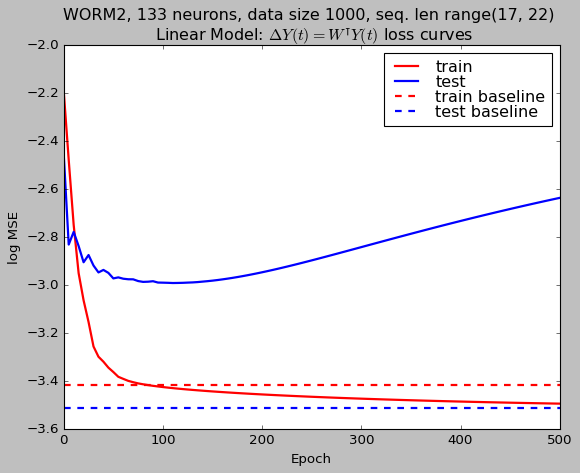

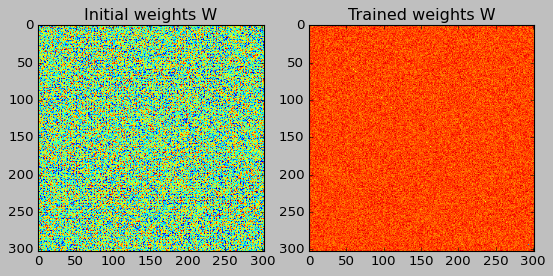

In [ ]:
#@title Plot loss curves for the linear model.
#@markdown

# plot loss curves
plot_loss_log(log, plt_title="%s, %s neurons, data size %s, seq. len %s \n "
"Linear Model: $\Delta Y(t) = W^{\intercal} Y(t)$ loss "
"curves"%(worm.upper(), num_neurons, log['data_size'], log['seq_len']))

# trained vs untrained weights
plot_before_after_weights(untrained_weights, trained_weights, W_name='W')

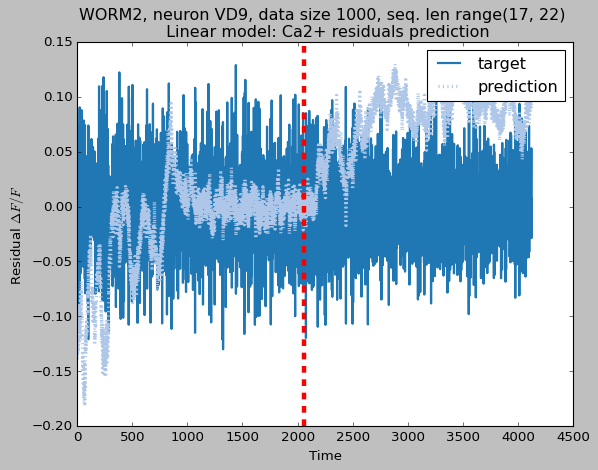


model test performance: tensor(0.0025, dtype=torch.float64)

signs flipped: tensor(0.0027, dtype=torch.float64)

baseline: tensor(0.0006, dtype=torch.float64)


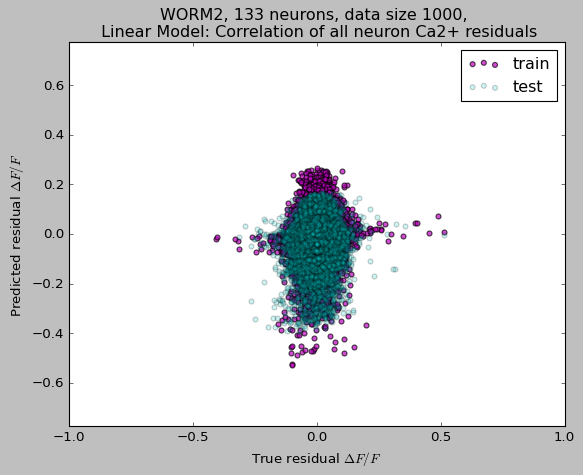

In [ ]:
#@title Make predictions with the trained linear model.
#@markdown 

targets, predictions = model_predict(new_calcium_data, lin_model)

# plot prediction for a single neuron
plot_target_prediction(targets[:, slot_idx], predictions[:, slot_idx], 
                       plt_title="%s, neuron %s, data size %s, seq. len %s \n "
                       "Linear model: Ca2+ residuals prediction"%(
                           worm.upper(), neuron, log['data_size'], log['seq_len']))

# plot scatterplot of all neuron predictions
plot_correlation_scatter(targets[:, mask], predictions[:, mask], 
                         plt_title="%s, %s neurons, data size %s, \n Linear "
                         "Model: Correlation of all neuron Ca2+ residuals"%(
                             worm.upper(), num_neurons, log['data_size']))

In [ ]:
#@title Train the linear model on increasingly more data.
#@markdown 

from worm_utils import plot_more_data_losses

results = more_data_training(LinearNN, single_worm_dataset, seq_len=range(17,22,1),
                             num_epochs=500, worm=worm, model_name="Linear")

model, log = results[-1]
worm, seq_len, num_neurons = log['worm'], log['seq_len'], log['num_neurons']

plot_more_data_losses(results, plt_title="%s, %s neurons, seq. len %s \n Linear"
" Model: Loss curves from scaling dataset size"%(worm.upper(), num_neurons, 
                                                 seq_len))

In [ ]:
#@title Train the linear model on multiple worms.
#@markdown

from worm_utils import plot_multi_worm_losses

results = multi_worm_training(LinearNN, all_worms_dataset, seq_len=range(17,22,1),
                              num_epochs=500, model_name="Linear")

num_worms = len(results)
model, log = results[-1]
seq_len = log['seq_len']

plot_multi_worm_losses(results, plt_title="%s worms, seq. len %s \n Linear "
"Model: Loss curves from different worms"%(num_worms, seq_len))

In [ ]:
#@title Train the linear model on many worms and test on a held-out worm.
#@markdown 

log = leave_one_worm_out_training(LinearNN, all_worms_dataset, seq_len=range(17,22,1),
                              num_epochs=500, model_name="Linear")

## RNN model.

### Using an LSTM model to predict $\vec{\Delta Y}$ given $\vec{Y}$.

We train an LSTM (a type of recurrent neural network, RNN) to output the next $L$ residuals $\begin{bmatrix} Y(t-L+2)-Y(t-L+1),\: Y(t-L+3)-Y(t-L+2),\: \dots,\: Y(t)-Y(t-1),\: \mathbf{Y(t+1)-Y(t)} \end{bmatrix}^{\top}$ given an input sequence $\begin{bmatrix} Y(t-L+1),\: Y(t-L+2),\: \dots,\: Y(t-1),\: \mathbf{Y(t)}\end{bmatrix}^{\top}$ of length $L$.

**Model:** $\Delta \vec{Y(t)} = f \left( \vec{Y(t)}; h_{t-1}, C_{t-1} \right), \: t=1,2,\dots, L$

The target is now the sequences of values at the next $L$ time-steps ($\tau=1$).

Notice how the linear model from earlier was like a **special case** of a sequence with unit length $L=1$.

In [ ]:
#@title Train a NetworkLSTM model.
#@markdown By "network" we mean that a single LSTM models the 
#@markdown entire network of neurons, rather than modeling each 
#@markdown neuron as an LSTM. 

from worm_utils import NetworkLSTM

# create the model and place on GPU
lstm_model = NetworkLSTM(input_size=302, 
                         hidden_size=302).double()
                
# store the initial input-output weights
_, _, _, init_W_io = np.split(lstm_model.lstm.weight_ih_l0.detach().cpu(), 4)

# optimize the model (use default settings)
lstm_model, log = optimize_model(dataset=new_calcium_data, model=lstm_model, 
                                 mask=mask, seq_len=range(17,22,1), num_epochs=500)

# get the trained weights 
_, _, _, final_W_io = np.split(lstm_model.lstm.weight_ih_l0.detach().cpu(), 4)

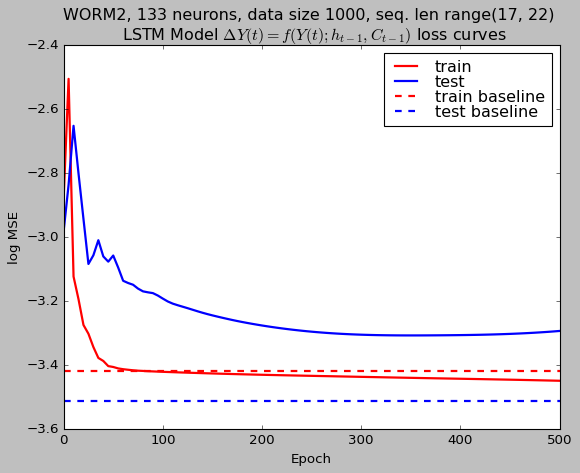

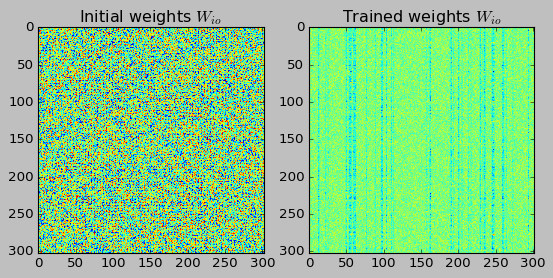

In [ ]:
#@title Plot loss curves for the LSTM model.
#@markdown 

# plot loss curves
plot_loss_log(log, plt_title="%s, %s neurons, data size %s, seq. len %s \n LSTM"
" Model $\Delta Y(t) = f ( Y(t); h_{t-1}, C_{t-1} )$ loss curves"%(
    worm.upper(), num_neurons, log['data_size'], log['seq_len']))

# trained vs untrained weights
plot_before_after_weights(init_W_io, final_W_io, W_name='$W_{io}$')

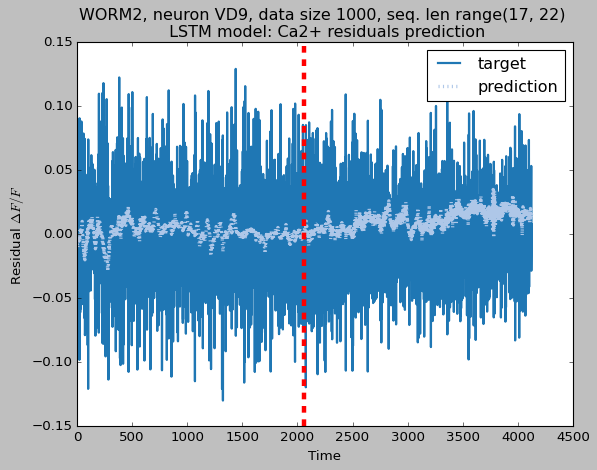


model test performance: tensor(0.0008, dtype=torch.float64)

signs flipped: tensor(0.0009, dtype=torch.float64)

baseline: tensor(0.0006, dtype=torch.float64)


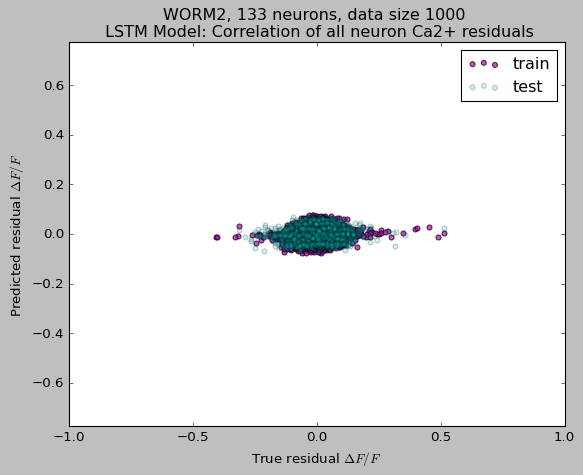

In [ ]:
#@title Make predictions with the trained LSTM model.
#@markdown 

targets, predictions = model_predict(new_calcium_data, lstm_model)

# plot prediction for a single neuron
plot_target_prediction(targets[:, slot_idx], predictions[:, slot_idx], 
                       plt_title="%s, neuron %s, data size %s, seq. len %s \n "
                       "LSTM model: Ca2+ residuals prediction"%(
                           worm.upper(), neuron, log['data_size'], log['seq_len']))

# plot scatterplot of all neuron predictions
plot_correlation_scatter(targets[:, mask], predictions[:, mask], 
                         plt_title="%s, %s neurons, data size %s \n LSTM Model:"
                         " Correlation of all neuron Ca2+ residuals"%(
                             worm.upper(), num_neurons, log['data_size']))

In [ ]:
#@title Train the LSTM model on increasingly more data.
#@markdown 

results = more_data_training(NetworkLSTM, single_worm_dataset, worm=worm, 
                             seq_len=range(17,22,1), num_epochs=500, model_name="LSTM")

model, log = results[-1]
worm, seq_len, num_neurons = log['worm'], log['seq_len'], log['num_neurons']

plot_more_data_losses(results, plt_title="%s, %s neurons, seq. len %s \n LSTM "
"Model: Loss curves from scaling dataset size"%(worm.upper(), num_neurons, seq_len))

In [ ]:
#@title Train the LSTM model on multiple worms.
#@markdown

results = multi_worm_training(NetworkLSTM, all_worms_dataset, 
                              seq_len=range(17,22,1), num_epochs=500, 
                              model_name="LSTM")

num_worms = len(results)
model, log = results[-1]
seq_len = log['seq_len']

plot_multi_worm_losses(results, plt_title="%s worms, seq. len %s \n LSTM Model:"
" Loss curves from different worms"%(num_worms, seq_len))

In [ ]:
#@title Train the LSTM model on many worms and test on a held-out worm.
#@markdown 

log = leave_one_worm_out_training(NetworkLSTM, all_worms_dataset, seq_len=range(17,22,1),
                              num_epochs=500, model_name="LSTM")

In [ ]:
#@title Experiment with different hidden sizes of the LSTM.
#@markdown 

def lstm_hidden_size_experiment(dataset, mask, num_epochs, input_size=302, 
                                num_layers=1, seq_len=1, 
                                hid_mult=np.array([5,4,3,2,1])):
  """
  Helper function to experiment with different input sizes for the LSTM model.
  dataset: the dataset to train on.
  num_epochs: number of epochs to train for.
  input_size: number of input features (neurons).
  num_layers: number of hidden layers to use in the LSTM.
  hid_mult: np.array of integers to multiple input_size by.
  seq_len: array of sequnce lengths to train on.
  """
  hidden_experiment = dict()
  # we experiment with different hidden sizes
  for hidden_size in input_size*hid_mult:
    hidden_size = int(hidden_size)
    print()
    print("Hidden size: %d" % hidden_size)
    print("~~~~~~~~~~~~~~~")
    # initialize model, optimizer and loss function
    lstm_model = NetworkLSTM(input_size, hidden_size, num_layers).double() 
    # optimize the model
    lstm_model, log = optimize_model(dataset=dataset, model=lstm_model, 
                                     mask=mask, num_epochs=num_epochs, 
                                     seq_len=seq_len)
    # log results of this experiment      
    hidden_experiment[hidden_size] = log
  return hidden_experiment

In [ ]:
#@title Plot loss curves for various LSTM hidden sizes.
#@markdown

from worm_utils import plot_hidden_experiment

hidden_experiment = lstm_hidden_size_experiment(dataset=new_calcium_data, 
                                                mask=mask,
                                                num_epochs=500, 
                                                input_size=302, 
                                                seq_len=range(17,22,1), 
                                                num_layers=1)

plot_hidden_experiment(hidden_experiment)

# Constructing the *C. elegans* connectome graph.


Currently we are using the connectome of Cook et al. (2019), found here: https://www.wormwiring.org/pages/software.html. 

It has come to our attention that this connectome is highly inaccurate. 

**TODO:** Use the latest connectome data for adult worms from Witvliet et al. (2021), found here: https://www.wormwiring.org/pages/witvliet.html.

## **Data Handling of Graphs**

A graph is used to model pairwise relations (edges) between objects (nodes). A single graph in PyG is described by an instance of `torch_geometric.data.Data`, which holds the following attributes by default:

`data.x`: Node feature matrix with shape `[num_nodes, num_node_features]`

`data.edge_index`: Graph connectivity in COO format with shape `[2, num_edges]` and type `torch.long`

`data.edge_attr`: Edge feature matrix with shape `[num_edges, num_edge_features]`

`data.y`: Target to train against (may have arbitrary shape), e.g., node-level targets of shape `[num_nodes, *]` or graph-level targets of shape `[1, *]`

`data.pos`: Node position matrix with shape `[num_nodes, num_dimensions]`



## Simple loading of the *C. elegans* graph.

In [ ]:
#@title Load the graph from preprocessed "raw" data.
#@markdown

# load the raw data
data_path = os.path.join(os.getcwd(), 'graph_tensors.pt')
print("Loading preprocessed data...")
graph_tensors = torch.load(data_path)

# make the graph
graph = Data(**graph_tensors)
graph.num_classes = len(graph.node_type) # TODO: make part of graph_tensors

# investigate the graph
print("Attributes:", "\n", graph.keys, "\n",
      f"Num. nodes {graph.num_nodes}, Num. edges {graph.num_edges}, " 
      f"Num. node features {graph.num_node_features}", end="\n")
print(f"\tHas isolated nodes: {graph.has_isolated_nodes()}")
print(f"\tHas self-loops: {graph.has_self_loops()}")
print(f"\tIs undirected: {graph.is_undirected()}")
print(f"\tIs directed: {graph.is_directed()}") 

Loading preprocessed data...
Attributes: 
 ['n_id', 'edge_index', 'pos', 'edge_attr', 'id_neuron', 'y', 'x', 'num_classes', 'node_type'] 
 Num. nodes 302, Num. edges 4396, Num. node features 1024
	Has isolated nodes: False
	Has self-loops: True
	Is undirected: False
	Is directed: True


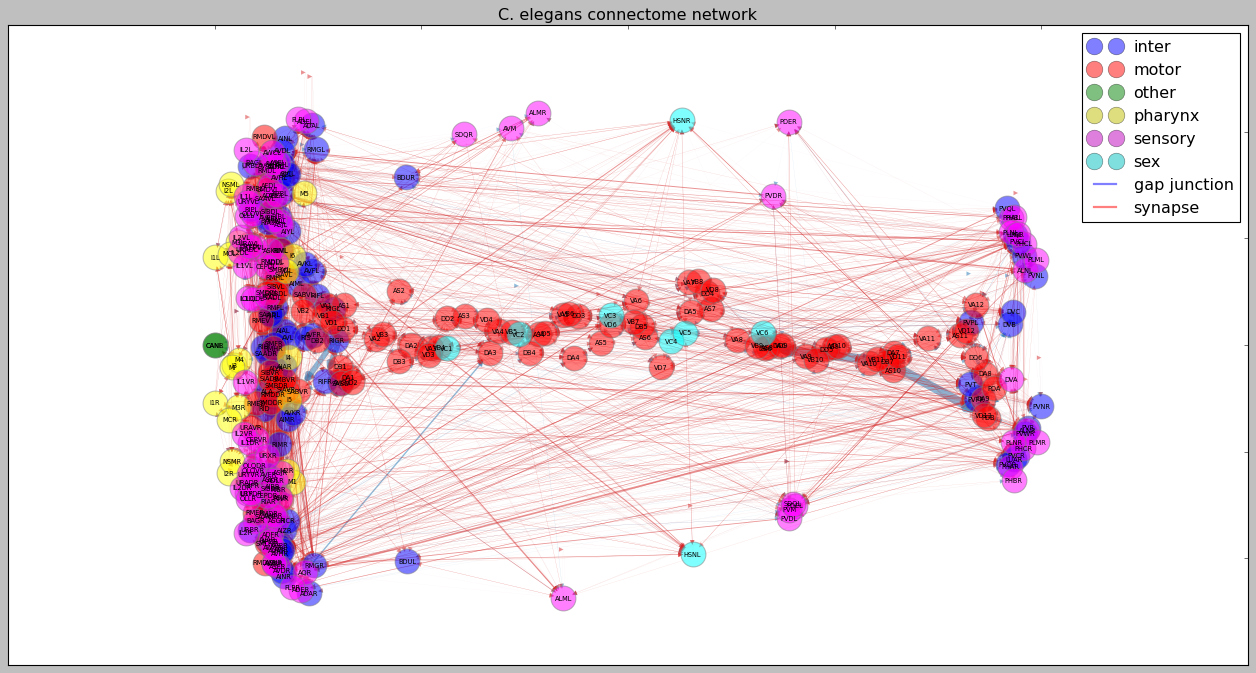

In [ ]:
#@title Graph of the *C. elegans* connectome.
#@markdown 

from worm_utils import draw_connectome

draw_connectome(graph)

# *C. elegans* neural prediction with a GNN.

Now that we have the connectome graph, we can train a Graph Neural Network (with architecture/flavor of our choosing) to perform a semi-supervised task (e.g. time series prediction).

## Placing neural data onto connectome graph.

When we made the connectome graph, we initialized the nodes features 
to be $1024$ timesteps of uniform random (interval $[0,1]$) noise. 
Indeed, if we skip or comment out this cell and train a GNN with these
random node features the network learns to predict the mean ($\sim0.5$) 
in order to minimize the loss!

To do something hopefully a bit more 
interesting, we will substitute the node features for as many neurons
as we have the real data for.

We have developed a way to map 
neuron identity to the corresponding activity traces. For neurons whose identities are unknown, we will set their features to be constant at $0$.

How much real data do we have? torch.Size([2397, 143])
Current data on connectome graph: (302, 1024)
Attributes: 
 ['edge_attr', 'y', 'x', 'num_classes', 'n_id', 'node_type', 'id_neuron', 'pos', 'edge_index'] 
 Num. nodes 51, Num. edges 269, Num. node features 2397
	Has isolated nodes: True
	Has self-loops: True
	Is undirected: False
	Is directed: True


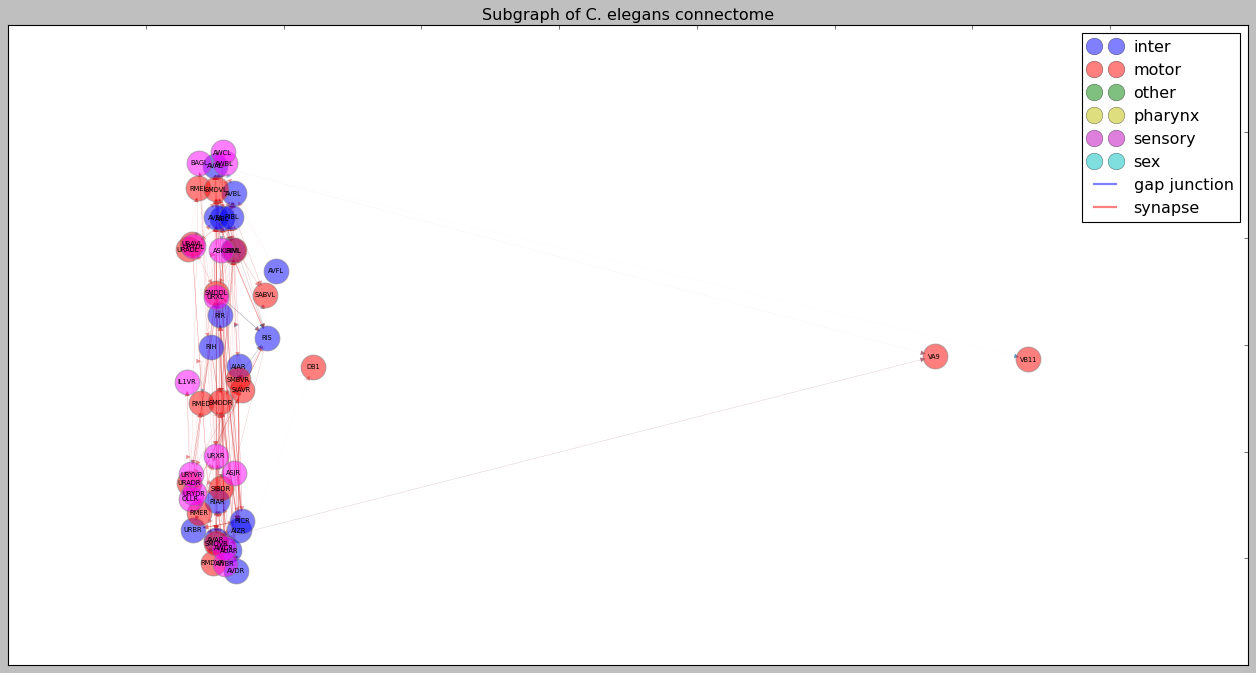

In [ ]:
#@title Replace the random data on the nodes with real data.
#@markdown 

from worm_utils import graph_inject_data, add_train_val_mask

# inject real data
graph, subgraph, subgraph_mask = graph_inject_data(single_worm_dataset, graph)
subgraph.num_classes = len(subgraph.node_type)

# add a train and validation mask
subgraph = add_train_val_mask(subgraph, train_ratio=0.6)

# draw the sub-network of labelled neurons
draw_connectome(subgraph, plt_title="Subgraph of C. elegans connectome")

In [ ]:
#@title Example of how to use `NeighborLoader`.
#@markdown

subgraph_loader = NeighborLoader(subgraph, input_nodes=None, 
                                 batch_size=1, num_neighbors=[-1], 
                                 shuffle=True)
gen = iter(subgraph_loader)
sample = next(gen)
sample.id_neuron = {i: graph.id_neuron[k] for i,k in 
                    enumerate(sample.n_id.cpu().numpy())}
sample.pos = {i: graph.pos[k] for i,k in 
              enumerate(sample.n_id.cpu().numpy())}

print(sample.num_nodes)
print(sample.batch_size), 
print(sample.y), 
print(sample.n_id),
print(sample.n_id[sample.edge_index])
print(sample)

7
1
tensor([4., 0., 4., 0., 0., 0., 4.], device='cuda:0')
tensor([255,  52,  78, 192, 203, 253, 257], device='cuda:0')
tensor([[ 52,  78, 192, 203, 253, 257],
        [255, 255, 255, 255, 255, 255]], device='cuda:0')
Data(
  x=[7, 2397],
  edge_index=[2, 6],
  edge_attr=[6, 2],
  y=[7],
  pos={
    0=[2],
    1=[2],
    2=[2],
    3=[2],
    4=[2],
    5=[2],
    6=[2]
  },
  node_type={
    0.0='InterNeurons',
    1.0='MotorNeurons',
    2.0='OtherEndOrgans',
    3.0='Pharynx',
    4.0='SensoryNeurons',
    5.0='SexSpecificCells'
  },
  num_classes=6,
  id_neuron={
    0='URXR',
    1='AUAR',
    2='BAGL',
    3='RICR',
    4='RIR',
    5='URBR',
    6='URYDR'
  },
  n_id=[7],
  train_mask=[7],
  val_mask=[7],
  input_id=[1],
  batch_size=1
)


In [ ]:
#@title Define a simple GNN model.
#@markdown 

class GraphNN(torch.nn.Module):
  '''
  
  '''
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(GraphNN, self).__init__()
    # need a distinct conv. layer for each type of synapse
    self.elec_conv = GCNConv(in_channels=input_dim, 
                             out_channels=hidden_dim)
    self.chem_conv = GCNConv(in_channels=input_dim, 
                             out_channels=hidden_dim)
    # readout layer transforms node features to output
    self.linear = torch.nn.Linear(in_features=2*hidden_dim, 
                                  out_features=output_dim)
    
  def loss_fn(self):
    '''The loss function to be used for this model.'''
    return torch.nn.CrossEntropyLoss()

  def reset_parameters(self):
    for conv in self.convs:
        conv.reset_parameters()
  
  def forward(self, graph):
    # x has shape [num_nodes, input_dim]
    # edge_index has shape [2, num_edges]
    x, edge_index, edge_attr = graph.x, graph.edge_index, graph.edge_attr
    elec_weight, chem_weight = edge_attr[:,0], edge_attr[:,1]
    elec_hid = self.elec_conv(x, edge_index, elec_weight)
    chem_hid = self.chem_conv(x, edge_index, chem_weight)
    hidden = torch.cat([elec_hid, chem_hid], dim=-1)
    output = self.linear(hidden)
    return output

In [ ]:
#@title Pytorch-style training and evaluation pipeline.
#@markdown

def train(train_loader, model, optimizer, no_grad=False):
    """
    Train a GNN model to perform neuron classification.
    Args:
        train_loader: NeighborLoader() on train graph
        model: instance of a PytorchGeometric GNN model
        optimizer: gradient descent optimization
    Returns:
    """
    model.train()
    criterion = model.loss_fn()
    total_loss = total_examples = 0
    for batch in train_loader: 
      optimizer.zero_grad() 
      y = batch.y[:batch.batch_size].to(torch.int64)
      yhat = model(batch)[:batch.batch_size]
      loss = criterion(yhat, y)
      loss.backward() 
      optimizer.step()  
      total_loss += loss.detach().item() * batch.batch_size
      total_examples += batch.batch_size
    train_loss = total_loss/total_examples
    return train_loss

@torch.no_grad()
def test(test_loader, model, no_grad=True):
    """
    Args:
        test_loader: NeighborLoader() on validation graph
        model: instance of a PytorchGeometric GNN model
    Returns:
    """
    model.eval()
    criterion = model.loss_fn()
    total_loss = total_examples = 0
    for batch in test_loader: 
      y = batch.y[:batch.batch_size].to(torch.int64)
      with torch.no_grad():
        ypred = model(batch)[:batch.batch_size]
        loss = criterion(ypred, y)
      total_loss += loss.detach().item() * batch.batch_size
      total_examples += batch.batch_size
    test_loss = total_loss/total_examples
    return test_loss

In [ ]:
#@title Train and evaluate a GNN model.
#@markdown 
import copy 

gnn_model = GraphNN(input_dim=subgraph.num_features, hidden_dim=1024, 
                    output_dim=subgraph.num_classes).double()
gnn_model = gnn_model.to(device)

optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.01)

train_loader = NeighborLoader(subgraph, 
                              input_nodes=subgraph.train_mask.cpu(), 
                              batch_size=1, num_neighbors=[-1], 
                              shuffle=False)
test_loader = NeighborLoader(copy.copy(subgraph), 
                             input_nodes=subgraph.val_mask.cpu(), 
                             batch_size=1, num_neighbors=[-1], 
                             shuffle=False)

# iterate over the training data multiple times
num_epochs = 100
logs = dict()
train_losses, test_losses = [], []
epochs = []
for epoch in range(num_epochs+1):
    # train the model
    train_loss = train(train_loader, gnn_model, optimizer)
    test_loss = test(test_loader, gnn_model)
    if epoch % 10 == 0:
      print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val. Loss: {test_loss:.4f}')
      epochs.append(epoch)
      train_losses.append(train_loss)
      test_losses.append(test_loss)
# log results of this experiment      
logs.update({'train_losses': train_losses, 
             'test_losses': test_losses,
             'epochs': epochs})

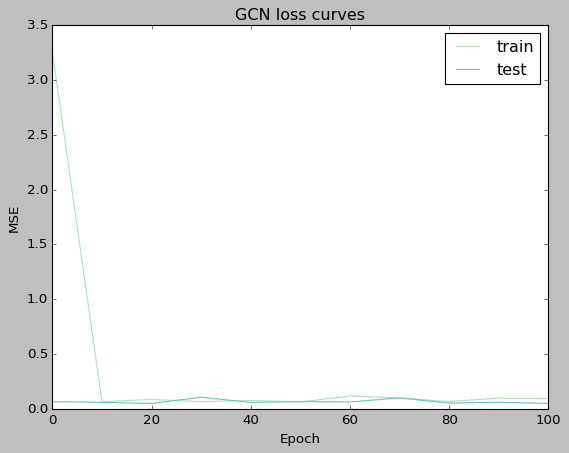

In [ ]:
#@title Plot loss curves.
#@markdown 

plt.figure()
plt.plot(logs['epochs'], logs['train_losses'], label='train')
plt.plot(logs['epochs'], logs['test_losses'], label='test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('GCN loss curves')
plt.legend()
plt.show()